In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 31.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33325,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.04 GiB
Comm: tcp://127.0.0.1:44823,Total threads: 4
Dashboard: http://127.0.0.1:43991/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:40467,


# Merge

In [3]:
config = pd.Series({
    'path': os.path.abspath('dades'),
    'file_type':'csv',
    'years':[2019, 2021, 2022],
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [4]:
%%time

def read_data_all(cnfg:dict):

    data = dict()

    for year in cnfg.years:
        cnfg['year'] = year
        data[year] = load_checkpoint(cnfg)
    
    return dd.concat(list(data.values()), interleave_partitions=False)
    
bbdd_completa = read_data_all(config)   

checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
CPU times: user 133 ms, sys: 12.2 ms, total: 145 ms
Wall time: 141 ms


In [5]:
%%time

index=0
before = get_ddf_shape(bbdd_completa)
print(before)

index+=1
print(index)
# 1 Error fix. # 2019 gener, febrer and marc have the status reversed
cond = (bbdd_completa.year == 2019) & (bbdd_completa.month.isin([1,2,3]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, ((bbdd_completa['status'] + 1) %2))
index+=1
print(index)
# 2 Remove not needed status, manitenance, planned. open = 0, closed = 1 
cond = (bbdd_completa['status'].isin([2.0,3.0]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, 1.0)
# bbdd_completa = bbdd_completa.dropna(subset=['status'])
index+=1
print(index)
# 3 Remove data from 2020
cond = (bbdd_completa['year'].isin([2020]))
bbdd_completa = bbdd_completa.mask(cond, np.nan)
bbdd_completa = bbdd_completa.dropna(subset=['year'])
index+=1
print(index)
# 4 2019 to 2020 to have continuos data 
cond = (bbdd_completa['year'].isin([2019]))
bbdd_completa['year'] = bbdd_completa['year'].mask(cond, bbdd_completa['year']+1)
index+=1
print(index)
# 5 status reversed 
bbdd_completa['status'] = (bbdd_completa['status'] + 1)%2
index+=1
print(index)
# 6 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_installed'])
index+=1
print(index)
# 7 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_charging_station'])
index+=1
print(index)
# 8 Remove row where status = closed and is renting and is returning
# cond = (bbdd_completa['status'].isin([0.0])) & (bbdd_completa['is_renting'].isin([1.0])) & (bbdd_completa['is_returning'].isin([1.0]))
# bbdd_completa = bbdd_completa.mask(cond, np.nan)
# bbdd_completa = bbdd_completa.dropna(subset=['status'])

after = get_ddf_shape(bbdd_completa)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(12419994, 23)
1
2
3
4
5
6
7
8
(11984228, 21)
Changes to dataframe durinf preprocessing
dropeed -435766 rows
dropped -2 columns
CPU times: user 4.19 s, sys: 227 ms, total: 4.42 s
Wall time: 17.3 s


In [6]:
%%time

unique_ids_by_year = bbdd_completa.groupby('year')['station_id'].unique().compute()
print(unique_ids_by_year)

# Calcula los station_id comunes en todos los años
common_ids = set(unique_ids_by_year[2020])
for year, ids in unique_ids_by_year.items():
    print(year, ids.shape)
    common_ids = common_ids.intersection(set(ids))
# common_ids
print(len(common_ids))

filtered_bbdd = bbdd_completa[bbdd_completa['station_id'].isin(common_ids)]
nonfiltered_bbdd = bbdd_completa[~bbdd_completa['station_id'].isin(common_ids)]

year
2020.0    [1.0, 320.0, 319.0, 318.0, 317.0, 316.0, 315.0...
2021.0    [1.0, 271.0, 400.0, 510.0, 26.0, 270.0, 269.0,...
2022.0    [1.0, 380.0, 28.0, 379.0, 378.0, 377.0, 376.0,...
Name: station_id, dtype: object
2020.0 (410,)
2021.0 (509,)
2022.0 (510,)
408
CPU times: user 1.52 s, sys: 69.5 ms, total: 1.59 s
Wall time: 9.97 s


In [7]:
%%time

before = get_ddf_shape(filtered_bbdd)
print(before)

filtered_bbdd = filtered_bbdd.drop_duplicates(subset=['timestamp', 'station_id'], keep='last')

after = get_ddf_shape(filtered_bbdd)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(10194539, 21)
(10100285, 21)
Changes to dataframe durinf preprocessing
dropeed -94254 rows
dropped 00 columns
CPU times: user 7.43 s, sys: 568 ms, total: 8 s
Wall time: 28.6 s


In [8]:
%%time

before = get_ddf_shape(nonfiltered_bbdd)
print(before)

nonfiltered_bbdd = nonfiltered_bbdd.drop_duplicates(subset=['timestamp', 'station_id'], keep='last')

after = get_ddf_shape(nonfiltered_bbdd)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(1789689, 21)
(1769381, 21)
Changes to dataframe durinf preprocessing
dropeed -20308 rows
dropped 00 columns
CPU times: user 7.27 s, sys: 610 ms, total: 7.88 s
Wall time: 25.4 s


## General view

In [9]:
bbdd_completa.columns

Index(['station_id', 'num_docks_available', 'num_bikes_available', 'status',
       'timestamp', 'is_renting', 'is_returning',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3',
       'ctx4'],
      dtype='object')

In [10]:

len(bbdd_completa.divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

37

In [11]:
bbdd_completa.head(2)

,station_id,num_docks_available,num_bikes_available,status,timestamp,is_renting,is_returning,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,year,month,dayofweek,day,dayofyear,hour,capacity,ctx0,ctx1,ctx2,ctx3,ctx4
0,1.0,8.363636,17.636364,1.0,1.546301e+09,1.0,1.0,17.636364,0.0,2020.0,1.0,1.0,1.0,1.0,0.0,46.0,0.181818,0.181818,0.181818,0.181818,0.181818
1,1.0,0.818182,26.181818,1.0,1.546380e+09,1.0,1.0,26.181818,0.0,2020.0,1.0,1.0,1.0,1.0,22.0,46.0,0.017787,0.021739,0.023715,0.106719,0.094203


In [12]:
%%time

get_ddf_shape(bbdd_completa)

CPU times: user 2.56 s, sys: 207 ms, total: 2.77 s
Wall time: 9.76 s


(12418388, 21)

In [13]:
%%time

nans = get_features_nans(bbdd_completa)

zeros = get_features_zero(bbdd_completa)

CPU times: user 8.05 s, sys: 717 ms, total: 8.77 s
Wall time: 38.5 s


In [14]:
nans

{}

In [15]:
zeros

{'num_docks_available': 1.0848751061732005,
 'num_bikes_available': 6.599616633012271,
 'status': 3.5436966537041683,
 'is_renting': 0.05322752035127264,
 'is_returning': 0.053155047176815545,
 'num_bikes_available_types.mechanical': 16.167082233217386,
 'num_bikes_available_types.ebike': 30.178554575682448,
 'dayofweek': 14.260288855526177,
 'hour': 4.314344180581248,
 'ctx0': 1.0848751061732005,
 'ctx1': 1.0829585933375572,
 'ctx2': 1.08014019210867,
 'ctx3': 1.077281528005084,
 'ctx4': 1.0745114422258348}

In [16]:
%%time 

uniques = get_columns_unique(bbdd_completa)

CPU times: user 27.4 s, sys: 2.71 s, total: 30.1 s
Wall time: 2min 58s


In [17]:
uniques

{'station_id': 0        1.0
 1      320.0
 2      319.0
 3      318.0
 4      317.0
        ...  
 507    446.0
 508     91.0
 509    467.0
 510     52.0
 511    431.0
 Name: station_id, Length: 512, dtype: float64,
 'num_docks_available': 0         8.363636
 1         0.818182
 2         0.000000
 3         6.818182
 4         7.909091
            ...    
 12264    24.370370
 12265    36.266667
 12266    19.151515
 12267     3.823529
 12268    24.433333
 Name: num_docks_available, Length: 12269, dtype: float64,
 'num_bikes_available': 0        17.636364
 1        26.181818
 2        27.000000
 3        21.181818
 4        20.181818
            ...    
 10336    29.333333
 10337     4.757576
 10338    24.176471
 10339     2.566667
 10340    52.708333
 Name: num_bikes_available, Length: 10341, dtype: float64,
 'status': 0    1.0
 1    0.0
 Name: status, dtype: float64,
 'timestamp': 0        1.546301e+09
 1        1.546380e+09
 2        1.546402e+09
 3        1.546416e+09
 4        1.54

In [18]:
xticks = np.asanyarray(
    (
        uniques['timestamp'].min(), 
        np.round(uniques['timestamp'].mean()-uniques['timestamp'].std()).astype(int),
        np.round(uniques['timestamp'].mean()).astype(int),
        np.round(uniques['timestamp'].mean()+uniques['timestamp'].std()).astype(int),
        uniques['timestamp'].max()
    )
)
xticks

array([1.54630080e+09, 1.57463877e+09, 1.61498426e+09, 1.65532975e+09,
       1.67252760e+09])

# Station IDs

In [19]:
%%time

print(stats.describe(bbdd_completa.station_id))
bbdd_completa.station_id.describe().compute()

DescribeResult(nobs=12418388, minmax=(1.0, 519.0), mean=248.4152513997791, variance=20784.90200443086, skewness=0.062140028922123385, kurtosis=-1.1124980742327335)
CPU times: user 3.53 s, sys: 696 ms, total: 4.22 s
Wall time: 18 s


count    1.241839e+07
mean     2.484153e+02
std      1.441697e+02
min      1.000000e+00
25%      1.330000e+02
50%      2.630000e+02
75%      3.900000e+02
max      5.190000e+02
Name: station_id, dtype: float64

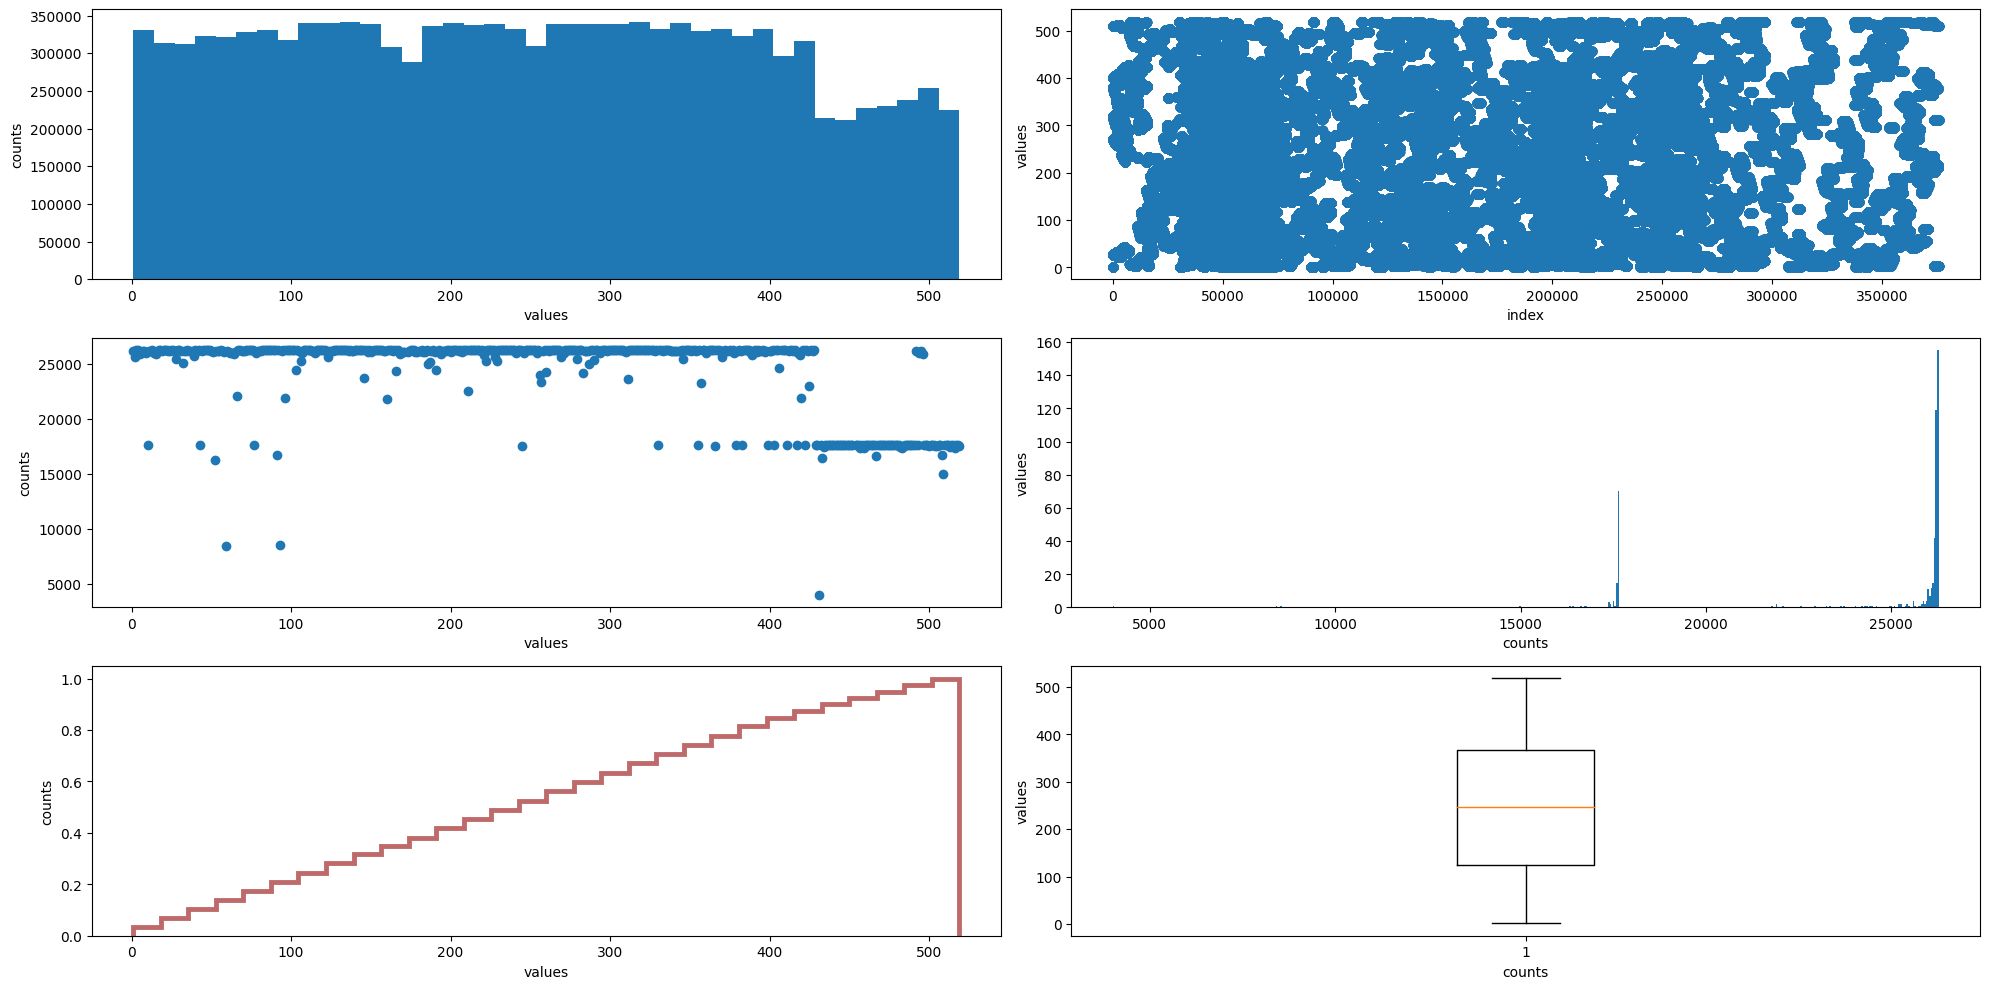

CPU times: user 20.1 s, sys: 1.88 s, total: 22 s
Wall time: 27.1 s


In [20]:
%%time

show_counts(bbdd_completa.station_id.compute())

# IDs comunes

In [21]:
%%time

get_ddf_shape(filtered_bbdd)
#bbdd_completa.shape = (12531377, 23)

CPU times: user 3.3 s, sys: 219 ms, total: 3.52 s
Wall time: 13.9 s


(10525889, 21)

2023-06-01 22:19:20,232 - distributed.worker.memory - WARNING - Worker is at 88% memory usage. Pausing worker.  Process memory: 5.50 GiB -- Worker memory limit: 6.21 GiB
2023-06-01 22:19:20,416 - distributed.worker.memory - WARNING - Worker is at 59% memory usage. Resuming worker. Process memory: 3.69 GiB -- Worker memory limit: 6.21 GiB


value counts stats {'max': 26029, 'mean': 25798.74754901961, 'median': 25974.0, 'std': 612.4266931963634, 'min': 21635}


  0%|          | 0/5 [00:00<?, ?it/s]

2023-06-01 22:20:22,984 - distributed.worker.memory - WARNING - Worker is at 88% memory usage. Pausing worker.  Process memory: 5.51 GiB -- Worker memory limit: 6.21 GiB
2023-06-01 22:20:23,168 - distributed.worker.memory - WARNING - Worker is at 59% memory usage. Resuming worker. Process memory: 3.70 GiB -- Worker memory limit: 6.21 GiB


CPU times: user 13.3 s, sys: 1.11 s, total: 14.4 s
Wall time: 1min 15s


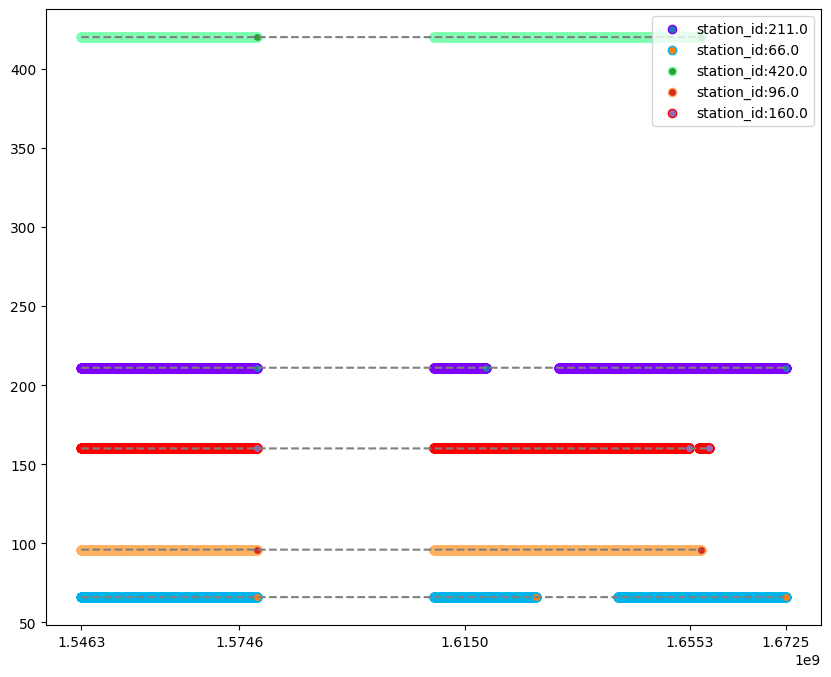

In [22]:
%%time

scatter_columns(
    filtered_bbdd, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8)
)

## IDs no comunes (testing)

In [23]:
%%time

get_ddf_shape(nonfiltered_bbdd)
#bbdd_completa.shape = (12531377, 23)

CPU times: user 2.99 s, sys: 195 ms, total: 3.19 s
Wall time: 10.7 s


(1771399, 21)

value counts stats {'max': 17440, 'mean': 17032.68269230769, 'median': 17432.5, 'std': 1817.4912682015276, 'min': 3927}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 9.08 s, sys: 822 ms, total: 9.9 s
Wall time: 57.2 s


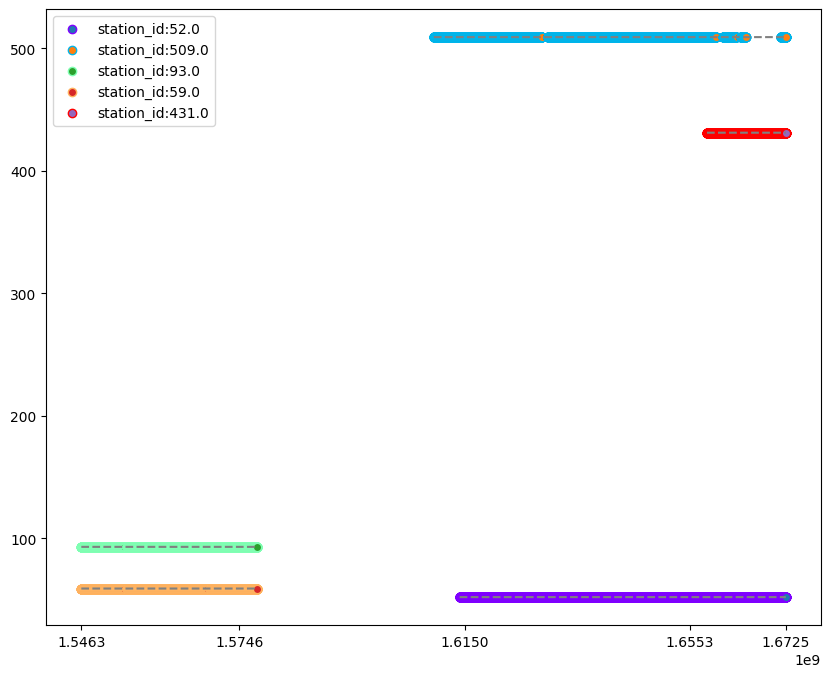

In [24]:
%%time

scatter_columns(
    nonfiltered_bbdd, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8)
)

# Data exploration__________________________________

## · Descriptiva
Media, mediana, desviación estándar, mínimo y máximo para columnas numéricas Idea general de la distribución y el rango de los valores en esas columnas.

<div>
    <table>
        <tr>
            <th><p>Camp<p><th>
            <th><p>Descripció<p><th>
        <tr>
        <tr>
            <td><p>last_updated<p><td>
            <td><p>Timestamp de l'arxiu<p><td>
        <tr>
        <tr>
            <td><p>ttl<p><td>
            <td><p>TimeToLive de la resposta<p><td>
        <tr>
        <tr>
            <td><p>data<p><td>
            <td><p>Contenidor d'arrays d'informació d'estacions<p><td>
        <tr>
        <tr>
            <td><p>stations<p><td>
            <td><p>Array de dades de cada estació<p><td>
        <tr>
        <tr>
            <td><p>station_id<p><td>
            <td><p>Identificador de l'estació<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available<p><td>
            <td><p>Nombre de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available_types<p><td>
            <td><p>Array de tipus de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>mechanical<p><td>
            <td><p>Nombre de bicicletes mecàniques disponibles<p><td>
        <tr>
        <tr>
            <td><p>ebike<p><td>
            <td><p>Nombre de bicicletes elèctriques disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_docks_available<p><td>
            <td><p>Nombre de ancoratges disponibles<p><td>
        <tr>
        <tr>
            <td><p>is_installed<p><td>
            <td><p>L'estació està correctament instalada (0-NO,1-SI)<p><td>
        <tr>
        <tr>
            <td><p>is_renting<p><td>
            <td><p>L'estació està proporcionant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>is_returning<p><td>
            <td><p>L'estació està ancorant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>last_reported<p><td>
            <td><p>Timestamp de la informació de l'estació<p><td>
        <tr>
        <tr>
            <td><p>is_charging_station<p><td>
            <td><p>L'estació té capacitat de càrrega de bicicletes elèctriques<p><td>
        <tr>
        <tr>
            <td><p>status<p><td>
            <td><p>
                Estat de l'estació (IN_SERVICE=En servei, CLOSED=Tancada)
                 ['IN_SERVICE', 'OPEN', 'OPN', 'CLS', 'CLOSED', 'NOT_IN_SERVICE', 'MAINTENANCE', 'PLANNED']                     [0, 0, 0, 1, 1, 1,  2, 3]
                <p><td>
        <tr>
    <table>
<div>

# Time columns 

## 'timestamp'

DescribeResult(nobs=10525889, minmax=(1546300800.0, 1672527600.0), mean=1615134627.1656485, variance=1621344401223730.0, skewness=-0.37251881925931535, kurtosis=-1.331196969802532)


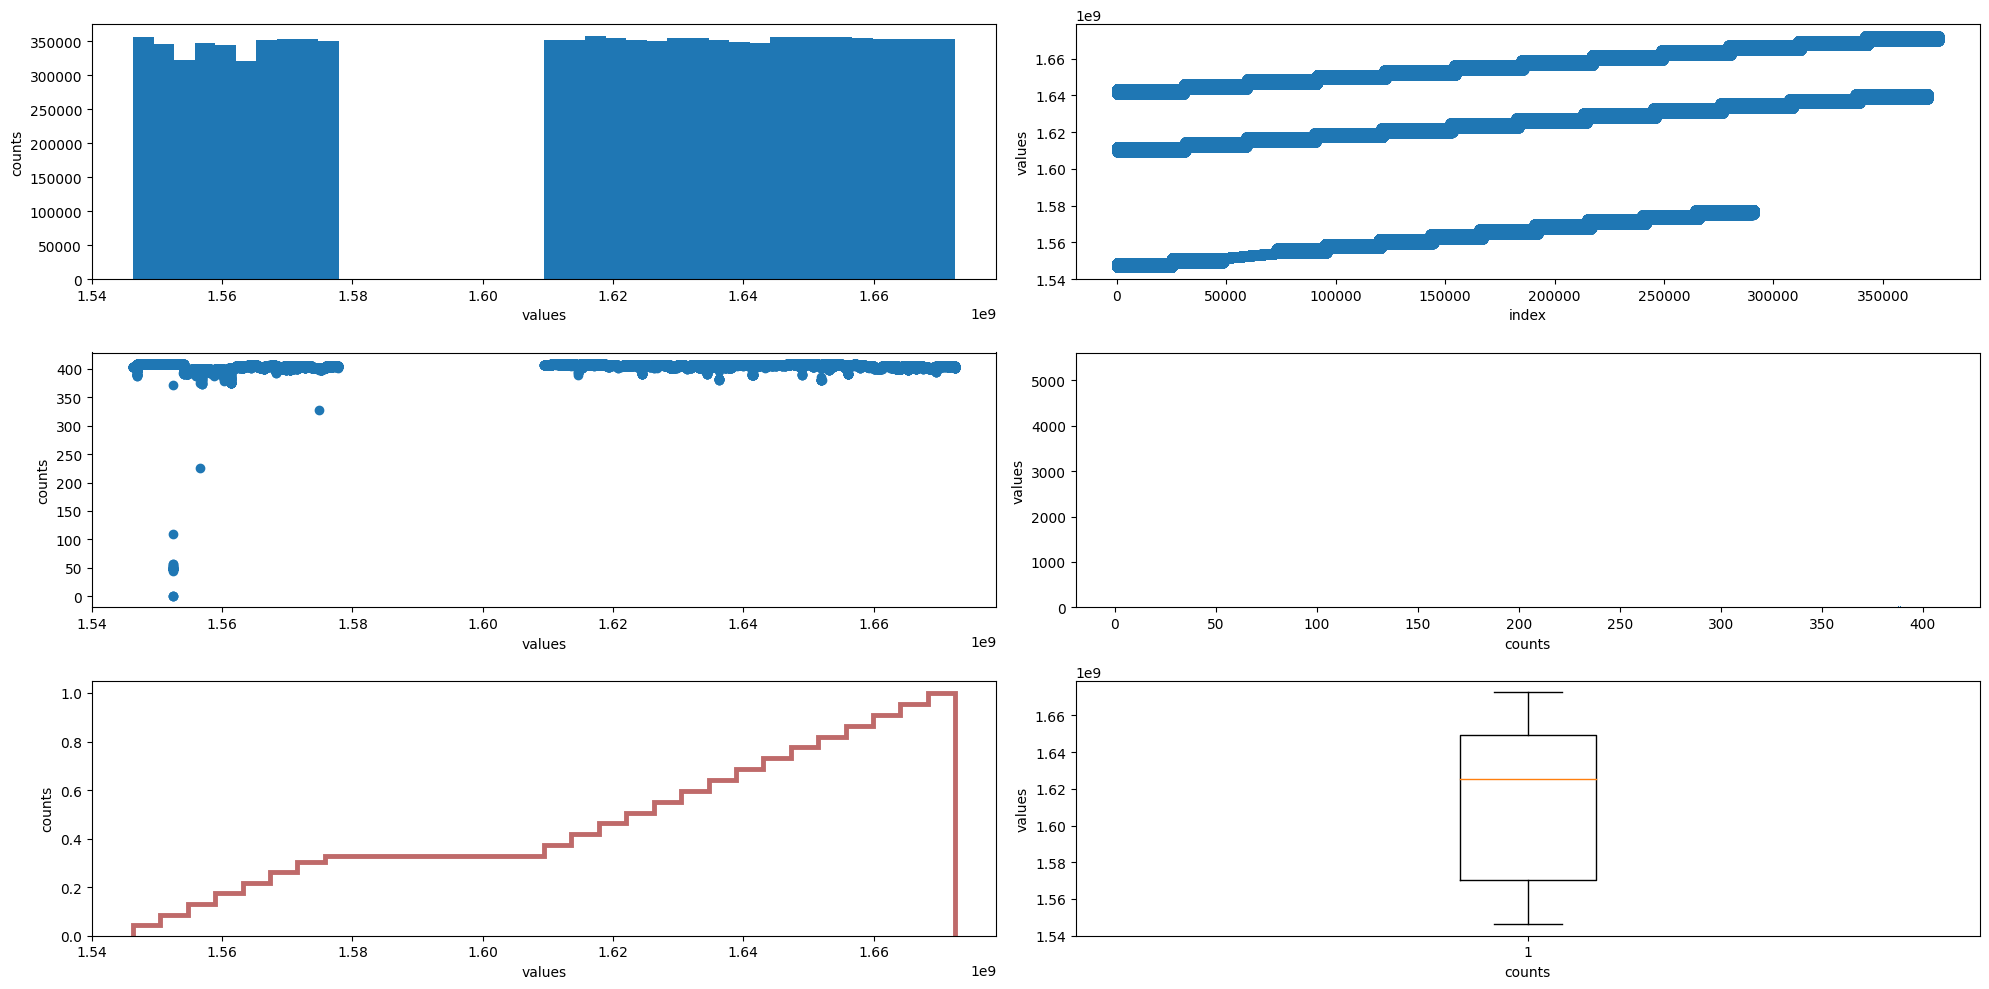

CPU times: user 51.2 s, sys: 5.67 s, total: 56.9 s
Wall time: 1min 12s


In [26]:
%%time
print(stats.describe(filtered_bbdd.timestamp))
filtered_bbdd.timestamp.describe()

show_counts(filtered_bbdd.timestamp.compute())

## 'year' 

2023-06-01 22:23:11,210 - distributed.worker.memory - WARNING - Worker is at 89% memory usage. Pausing worker.  Process memory: 5.54 GiB -- Worker memory limit: 6.21 GiB
2023-06-01 22:23:11,392 - distributed.worker.memory - WARNING - Worker is at 60% memory usage. Resuming worker. Process memory: 3.73 GiB -- Worker memory limit: 6.21 GiB


DescribeResult(nobs=10525889, minmax=(2020.0, 2022.0), mean=2021.0086126692006, variance=0.6642311992927329, skewness=-0.01579452290142212, kurtosis=-1.4943342557673693)


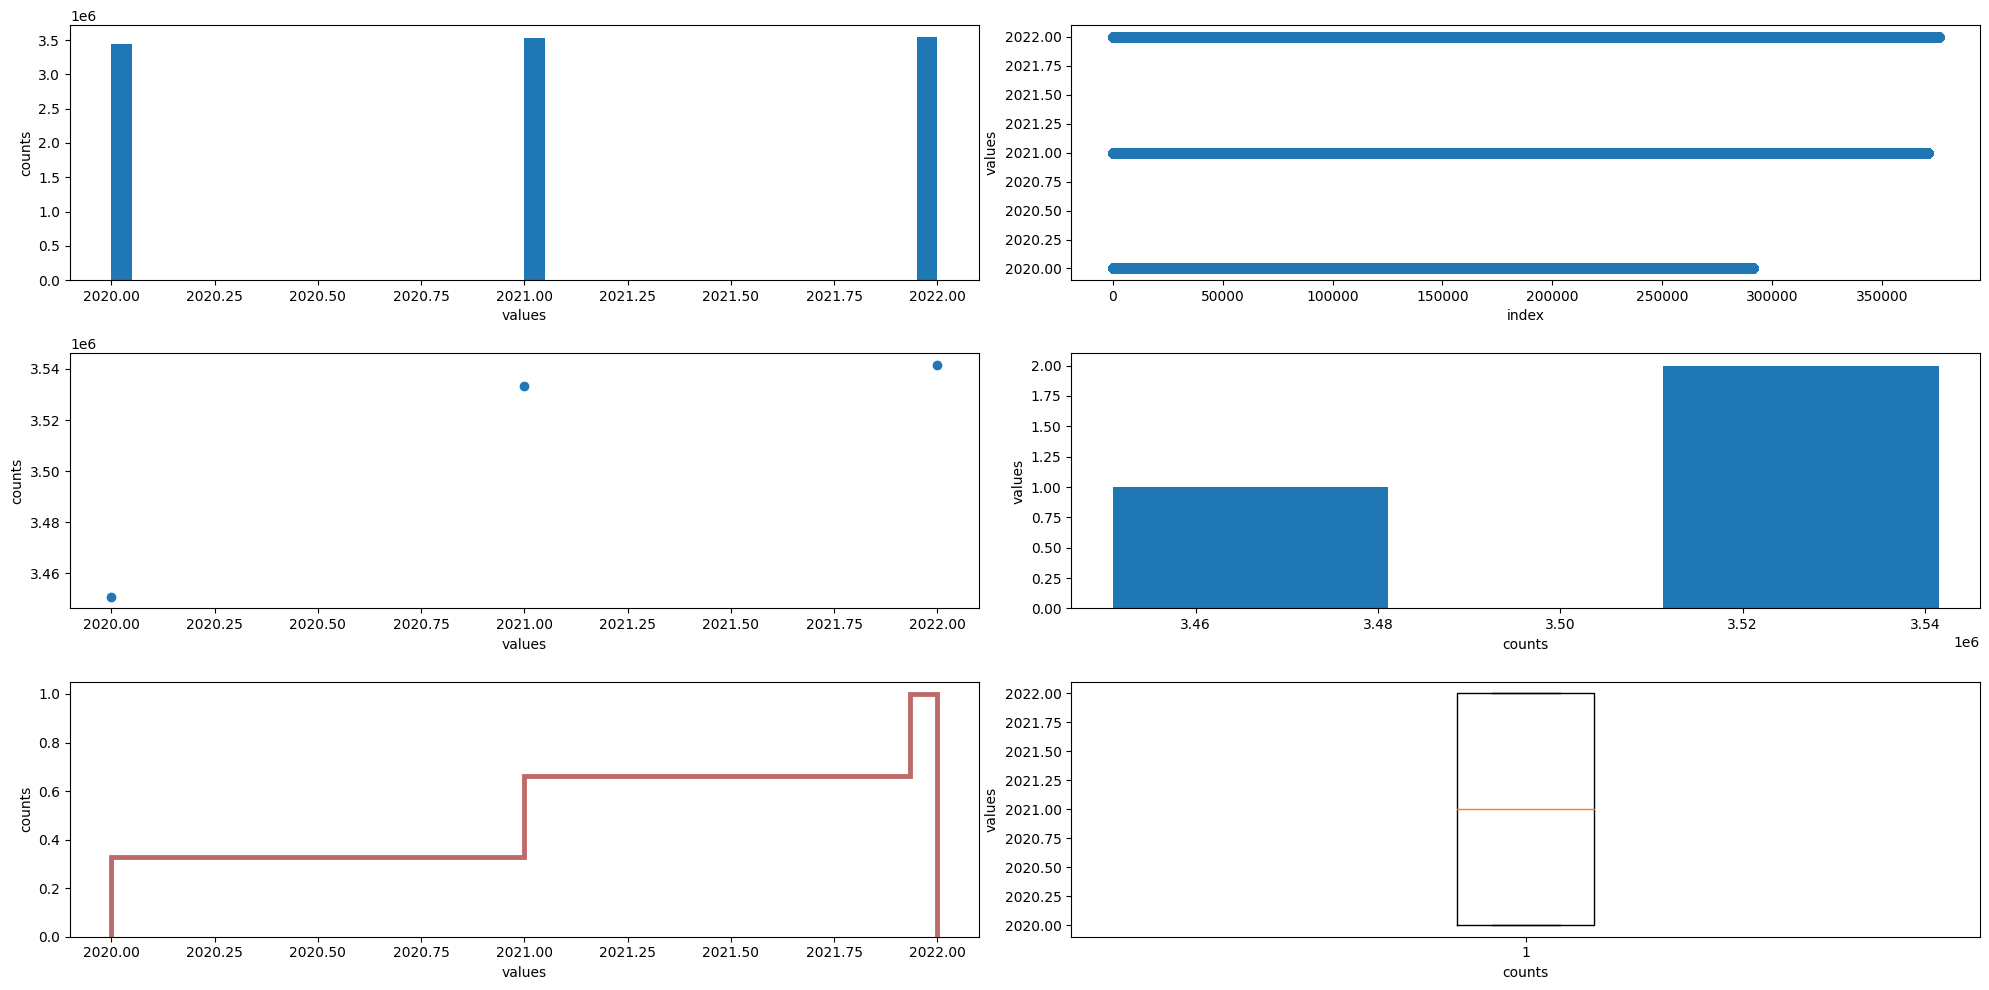

CPU times: user 19.7 s, sys: 1.46 s, total: 21.2 s
Wall time: 42.6 s


In [27]:
%%time
print(stats.describe(filtered_bbdd.year))
filtered_bbdd.year.describe()
show_counts(filtered_bbdd.year.compute())

## 'month'

DescribeResult(nobs=10525889, minmax=(1.0, 12.0), mean=6.527321160236442, variance=11.939704587812425, skewness=-0.013588915802726276, kurtosis=-1.2137701934723566)


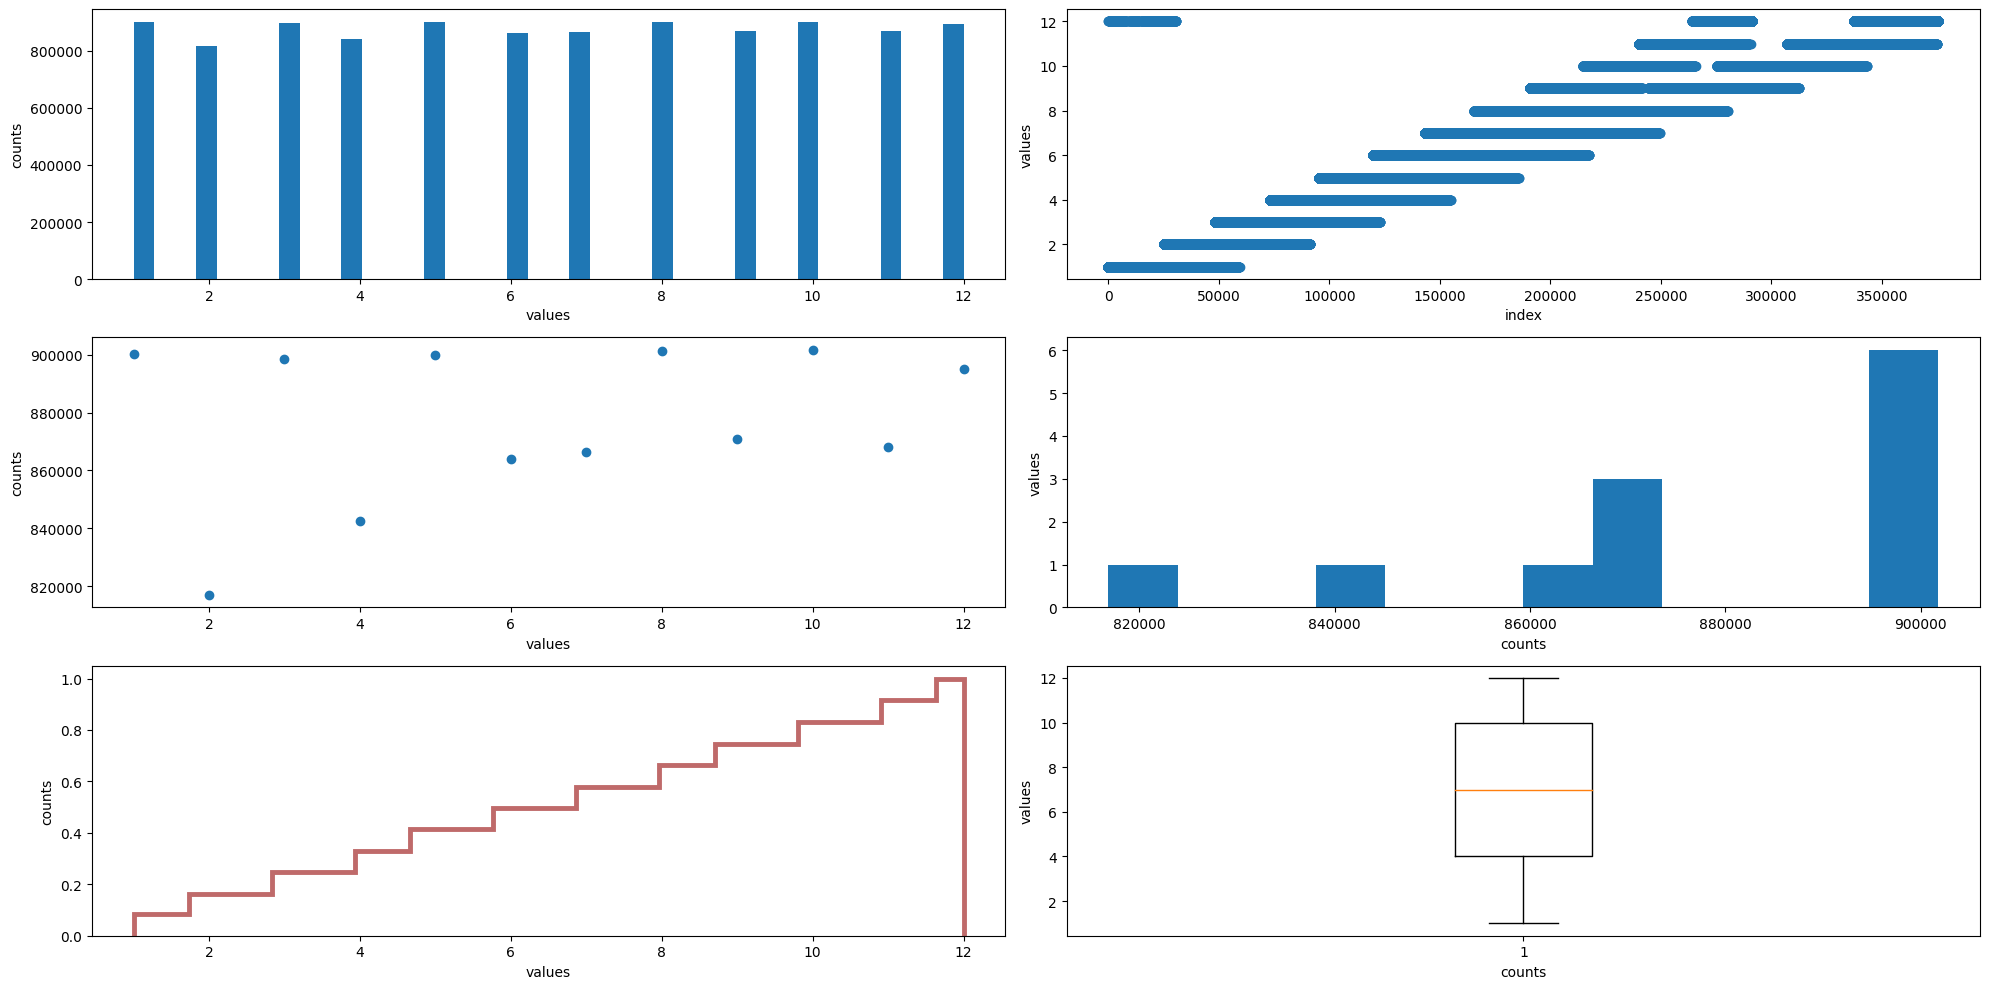

CPU times: user 19.7 s, sys: 1.32 s, total: 21 s
Wall time: 41.6 s


In [28]:
%%time
print(stats.describe(filtered_bbdd.month))
filtered_bbdd.month.describe()
show_counts(filtered_bbdd.month.compute())

## 'dayofweek' 

DescribeResult(nobs=10525889, minmax=(0.0, 6.0), mean=3.002360560708934, variance=4.003582628577089, skewness=-0.0023063753741316365, kurtosis=-1.2528698218756706)


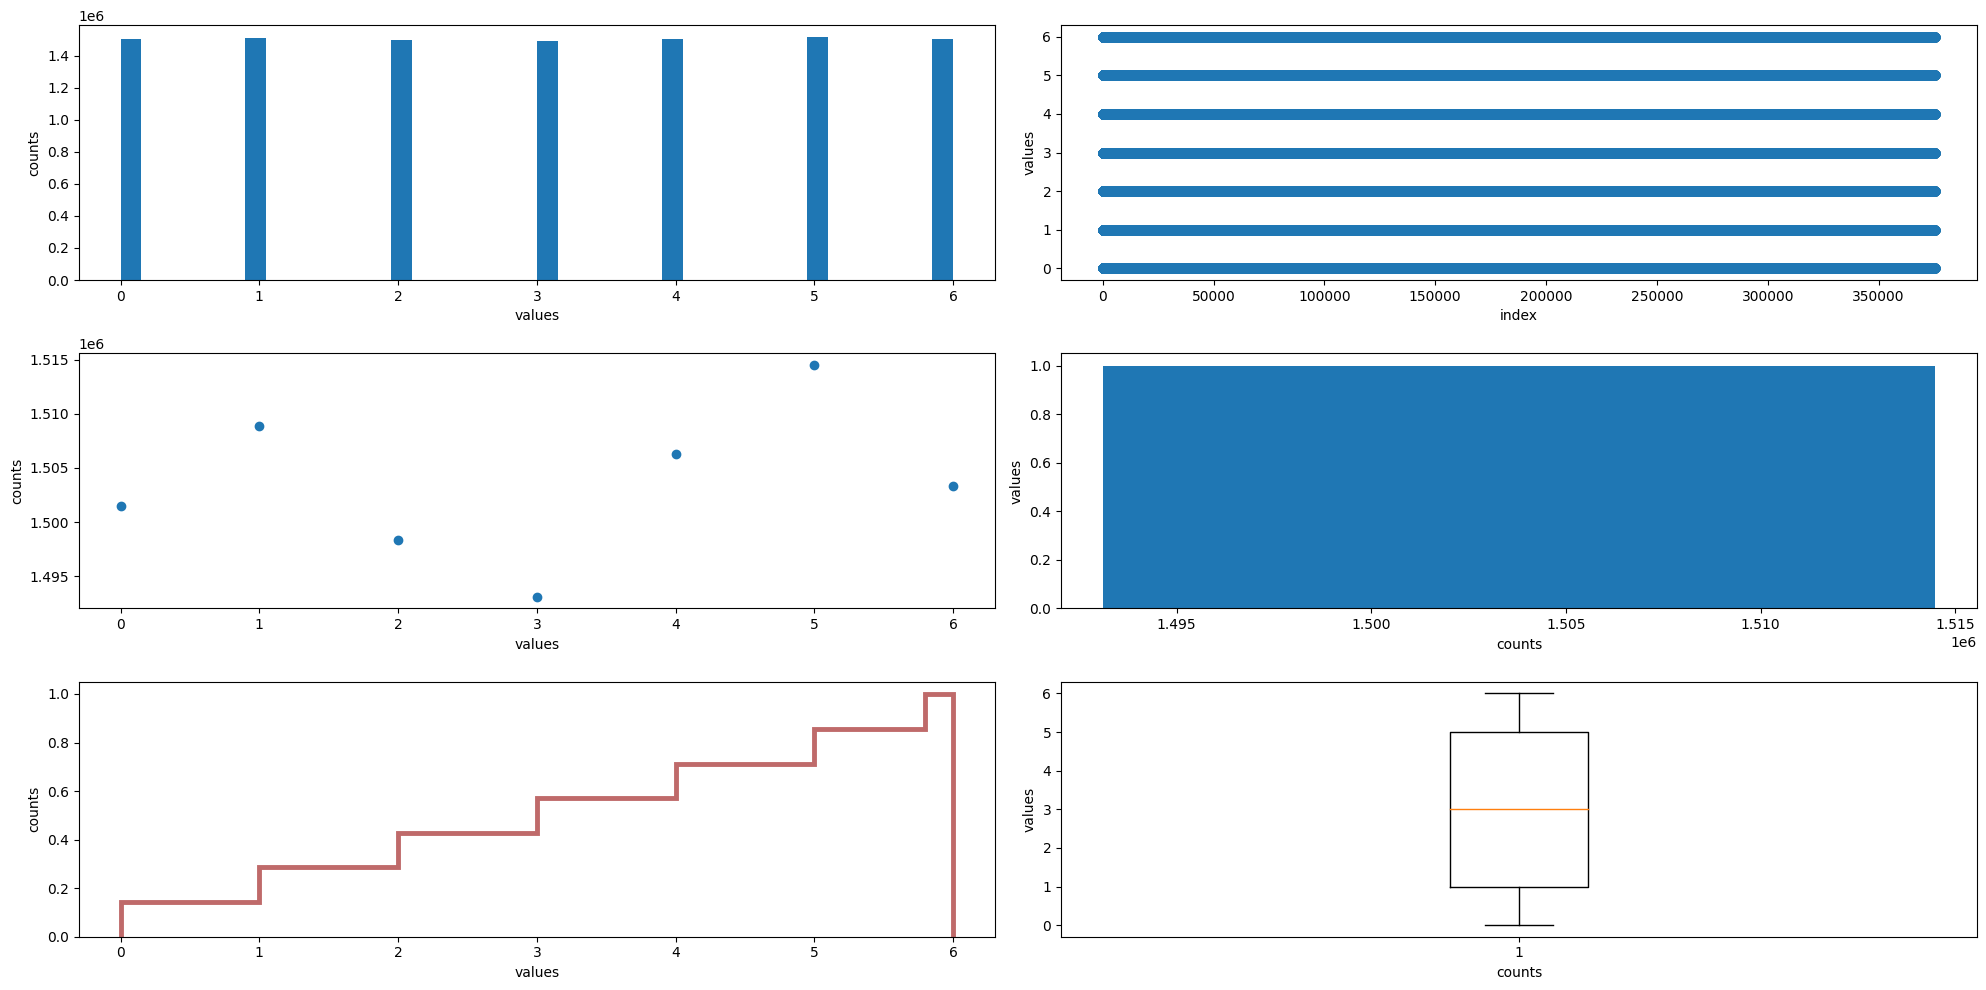

CPU times: user 19.6 s, sys: 1.51 s, total: 21.1 s
Wall time: 41.7 s


In [29]:
%%time
print(stats.describe(filtered_bbdd.dayofweek))
filtered_bbdd.dayofweek.describe()
show_counts(filtered_bbdd.dayofweek.compute())

## 'day'

DescribeResult(nobs=10525889, minmax=(1.0, 31.0), mean=15.73363428020189, variance=77.08389380945685, skewness=0.005549781150405047, kurtosis=-1.1865042879785268)


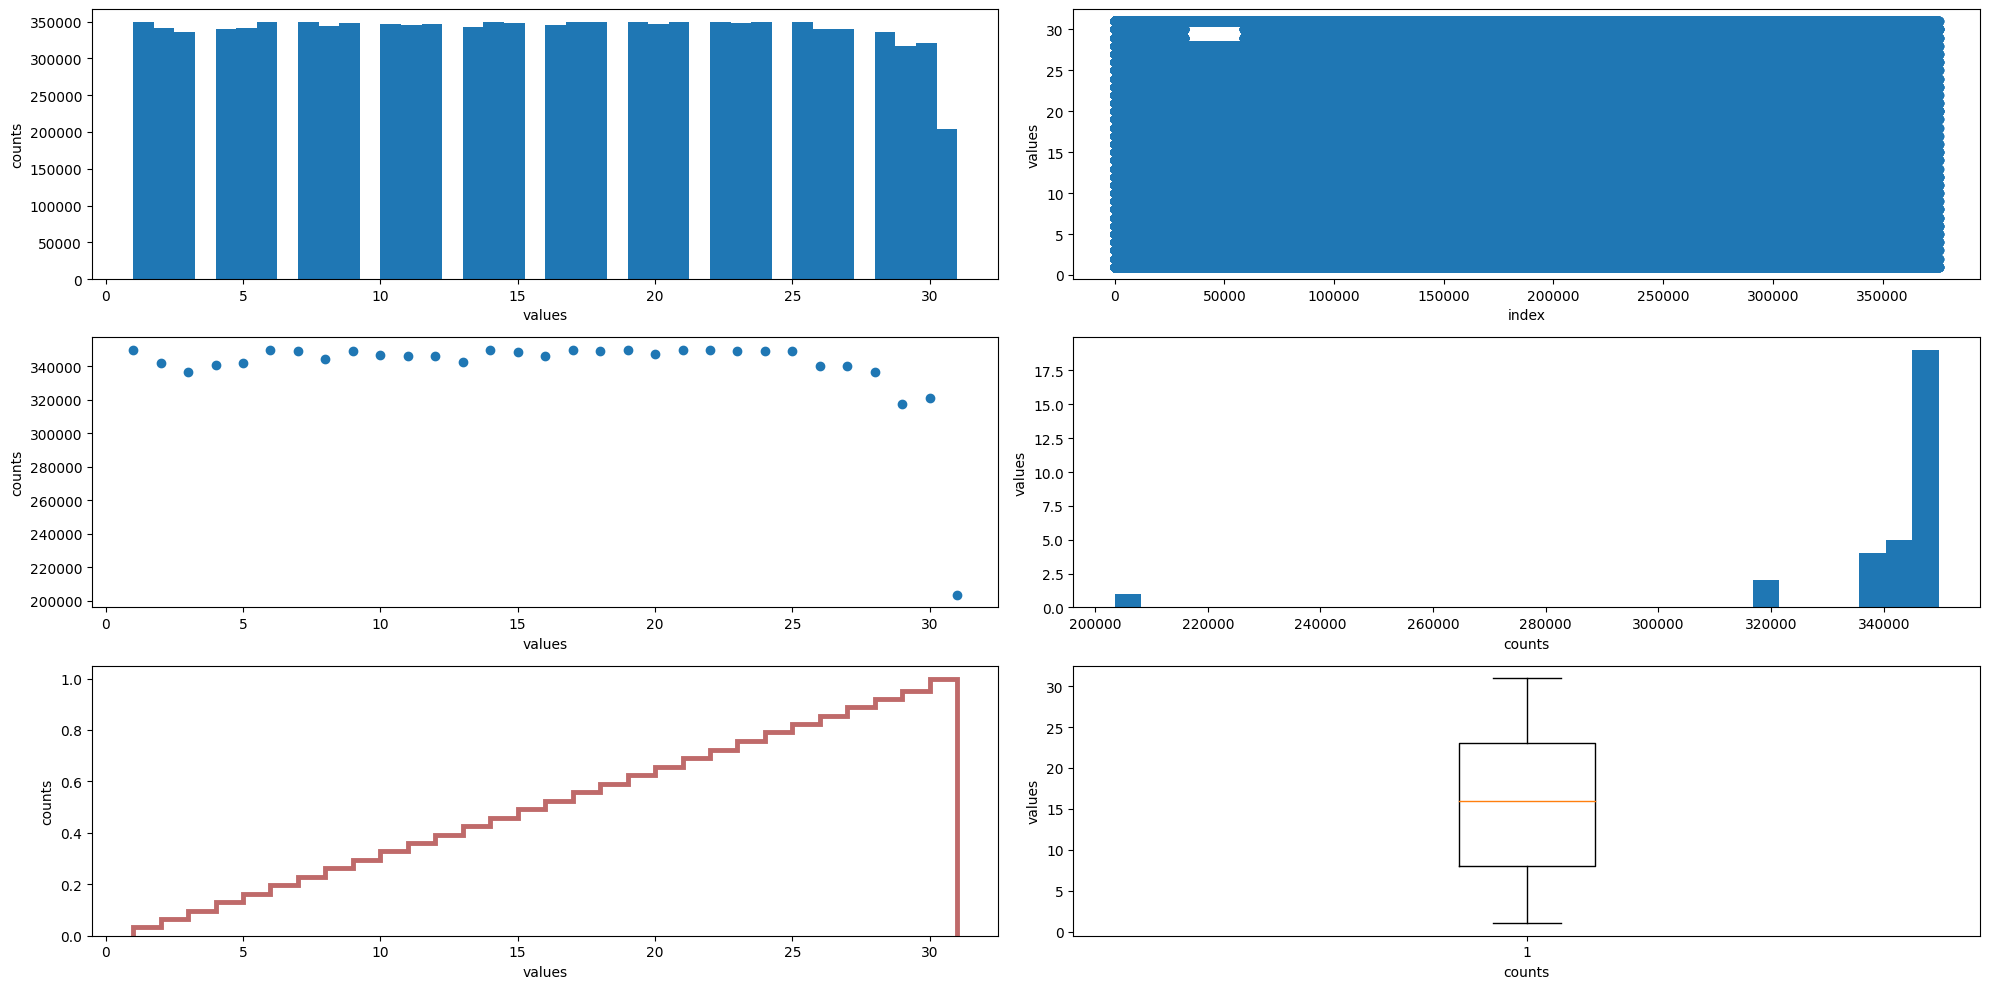

CPU times: user 19.6 s, sys: 1.42 s, total: 21 s
Wall time: 41.3 s


In [30]:
%%time
print(stats.describe(filtered_bbdd.day))
filtered_bbdd.day.describe()
show_counts(filtered_bbdd.day.compute())

## 'dayofyear' 

DescribeResult(nobs=10525889, minmax=(1.0, 365.0), mean=183.05644634861721, variance=11144.55961535169, skewness=-0.0019420339861114314, kurtosis=-1.2049875269718258)


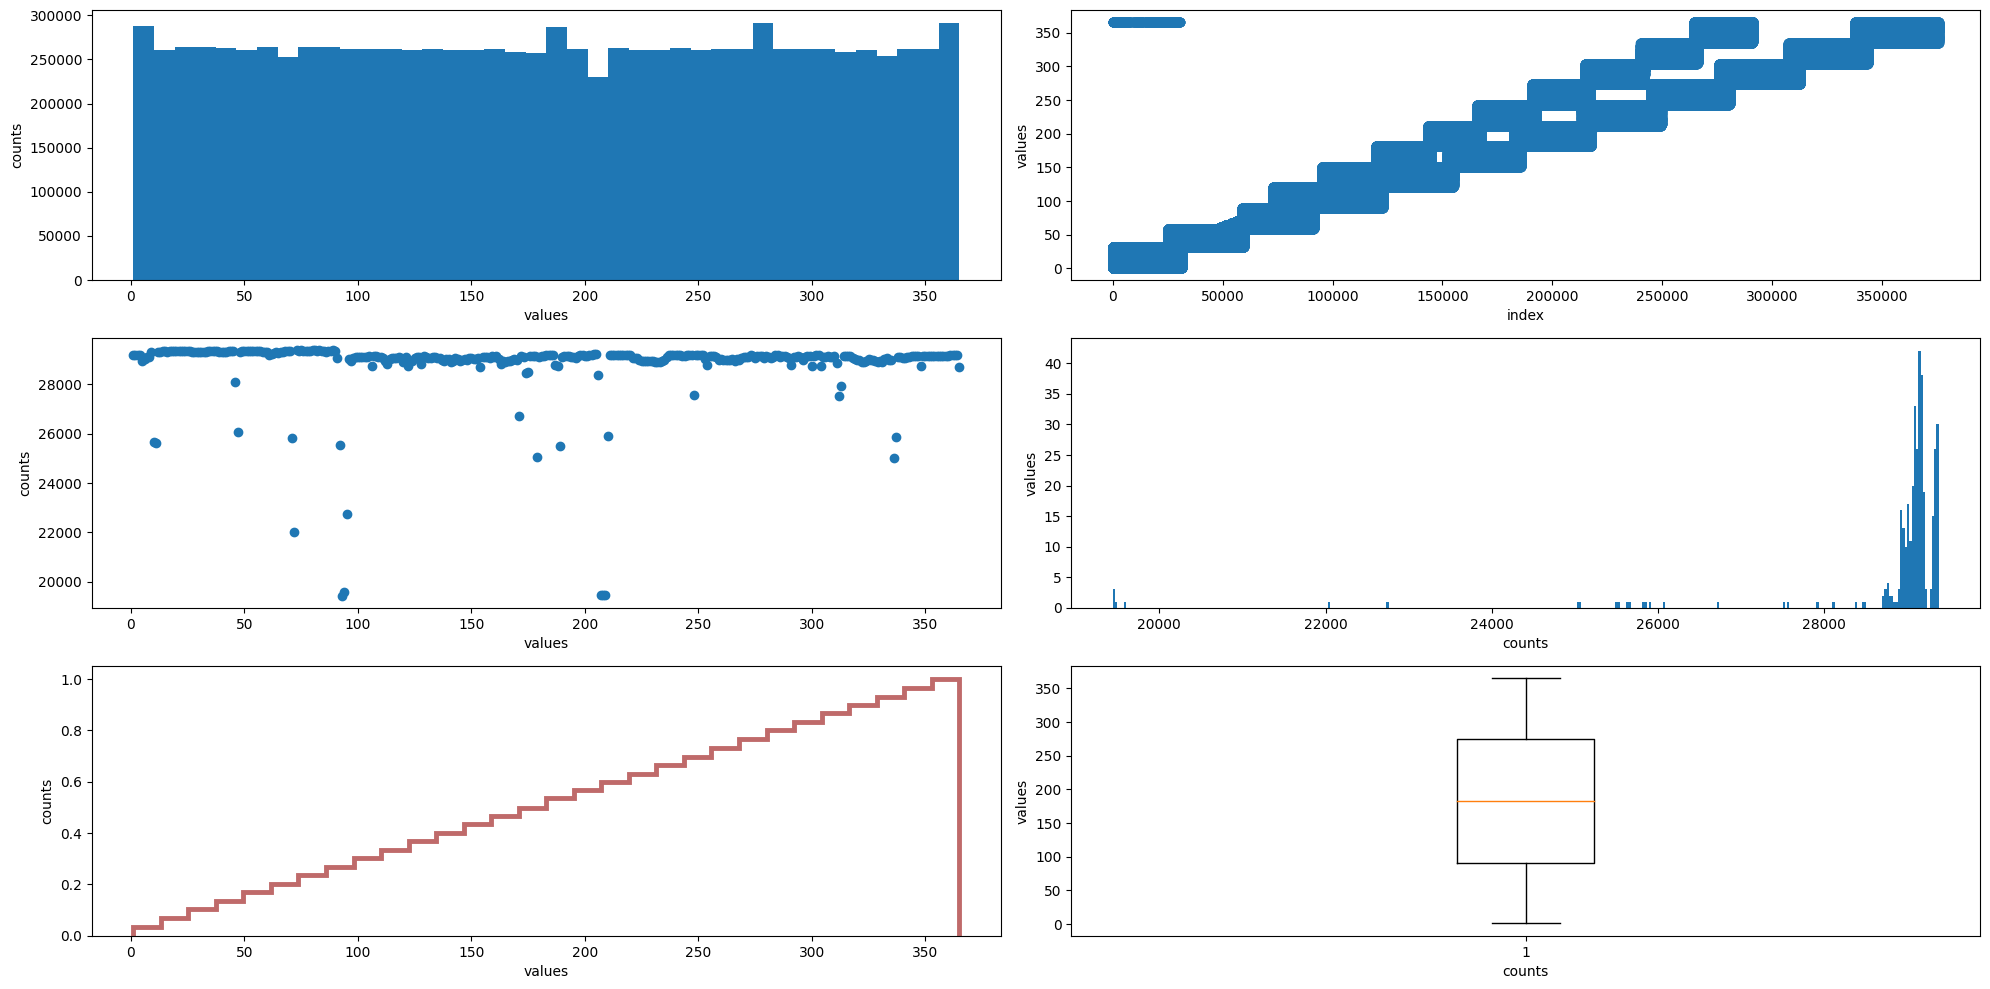

CPU times: user 19.6 s, sys: 1.63 s, total: 21.3 s
Wall time: 41.5 s


In [31]:
%%time
print(stats.describe(filtered_bbdd.dayofyear))
filtered_bbdd.dayofyear.describe()
show_counts(filtered_bbdd.dayofyear.compute())

## 'hour'

DescribeResult(nobs=10525889, minmax=(0.0, 23.0), mean=11.507948544773749, variance=47.861790020094034, skewness=-0.001856511432774868, kurtosis=-1.2028408259070458)


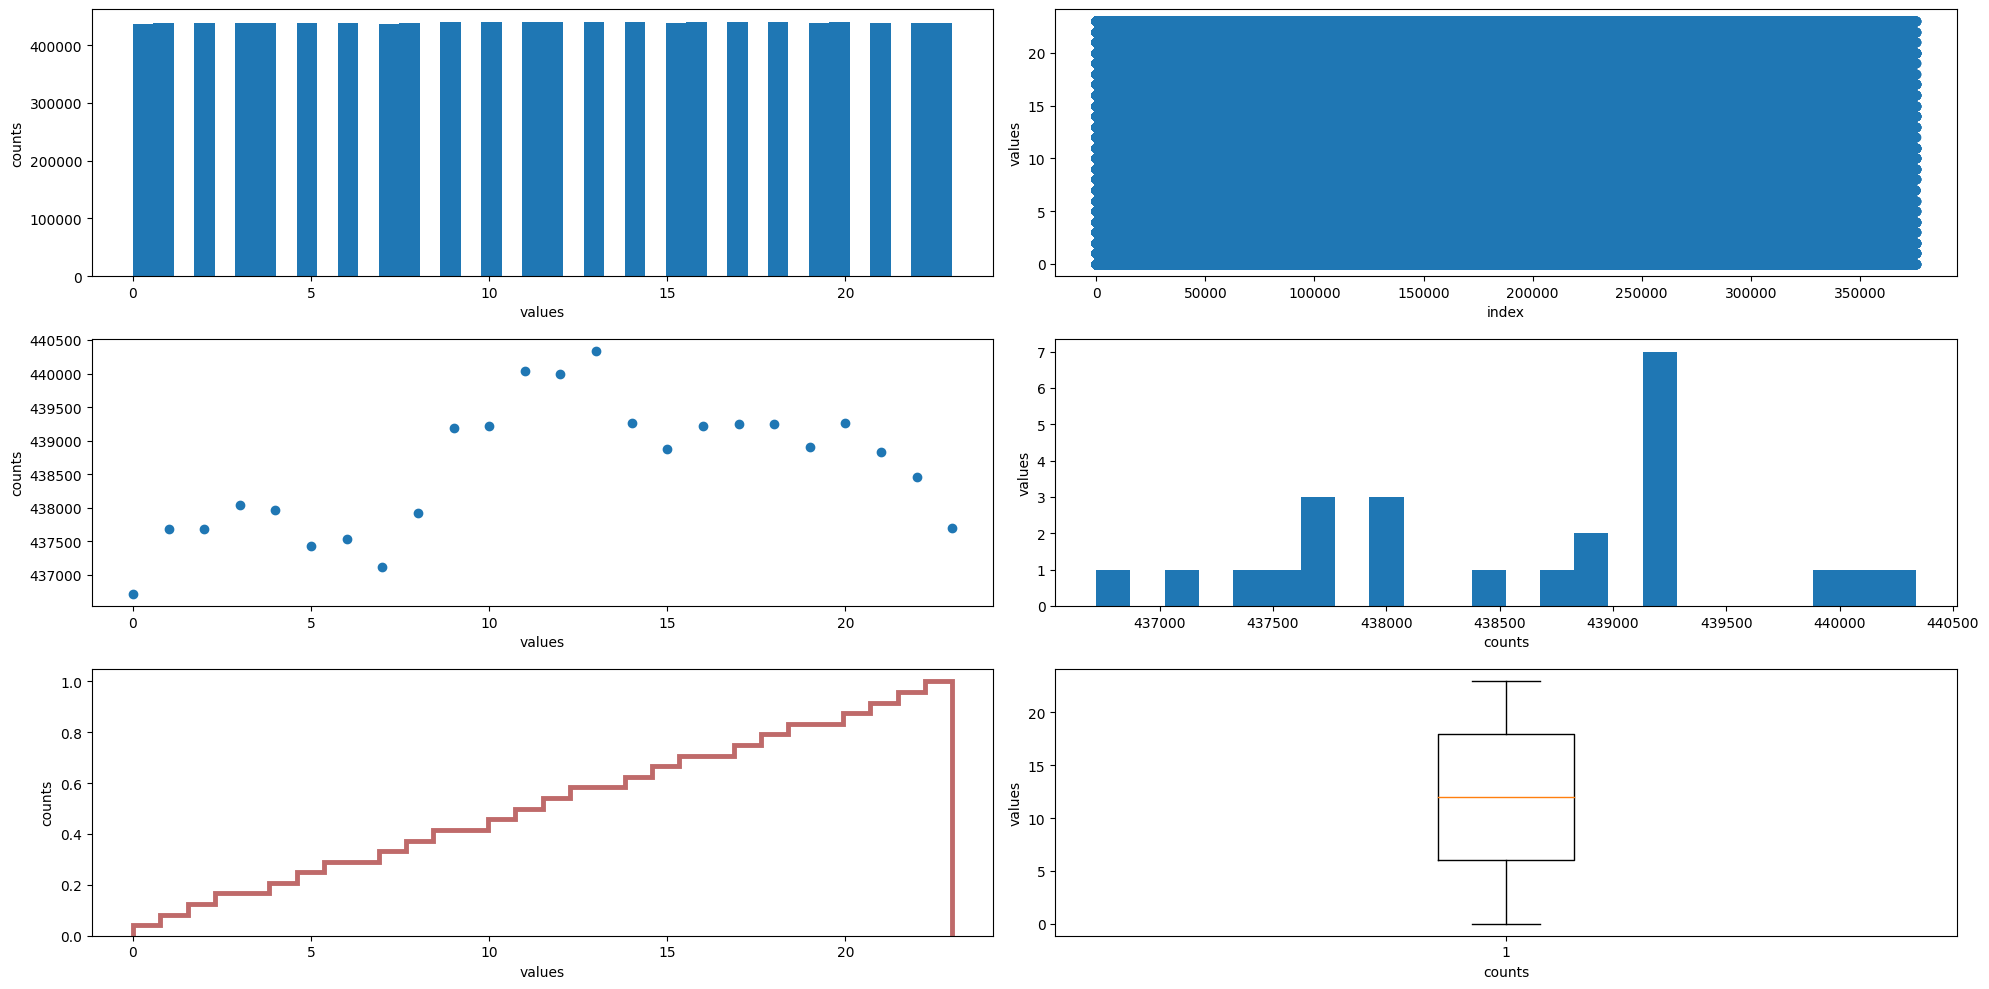

CPU times: user 19.5 s, sys: 1.63 s, total: 21.1 s
Wall time: 41.8 s


In [32]:
%%time
print(stats.describe(filtered_bbdd.hour))
filtered_bbdd.hour.describe()
show_counts(filtered_bbdd.hour.compute())

# Status Columns 

## 'status'

DescribeResult(nobs=10525889, minmax=(0.0, 1.0), mean=0.9590516297483281, variance=0.03927160495635804, skewness=-4.632892516639518, kurtosis=19.46369307073442)


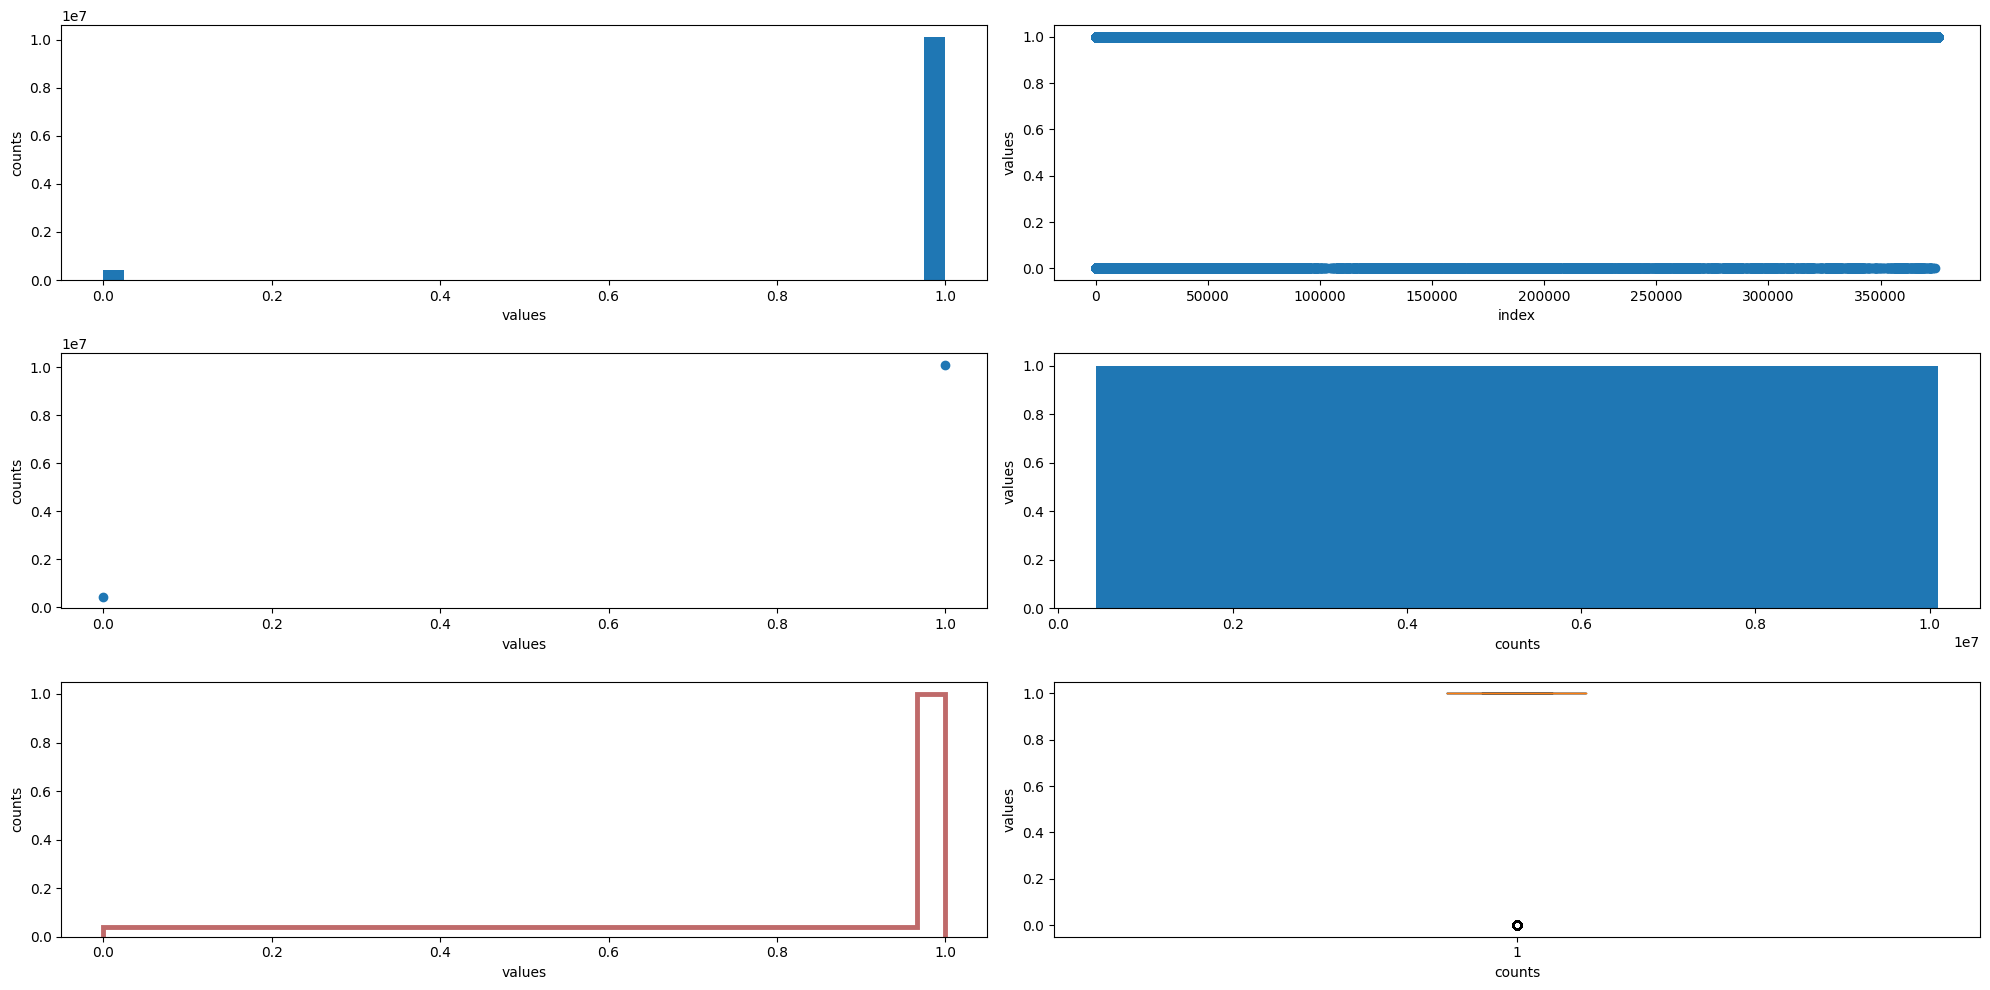

CPU times: user 19.7 s, sys: 1.43 s, total: 21.2 s
Wall time: 41.5 s


In [33]:
%%time
print(stats.describe(filtered_bbdd.status))
filtered_bbdd.status.describe()
show_counts(filtered_bbdd.status.compute())

## 'is_installed'

## 'is_renting'

DescribeResult(nobs=10525889, minmax=(0.0, 1.0), mean=0.9994670283906661, variance=0.0005326876012049198, skewness=-43.281324867377066, kurtosis=1871.2730822754352)


2023-06-01 22:28:17,043 - distributed.worker.memory - WARNING - Worker is at 89% memory usage. Pausing worker.  Process memory: 5.58 GiB -- Worker memory limit: 6.21 GiB
2023-06-01 22:28:17,230 - distributed.worker.memory - WARNING - Worker is at 60% memory usage. Resuming worker. Process memory: 3.77 GiB -- Worker memory limit: 6.21 GiB


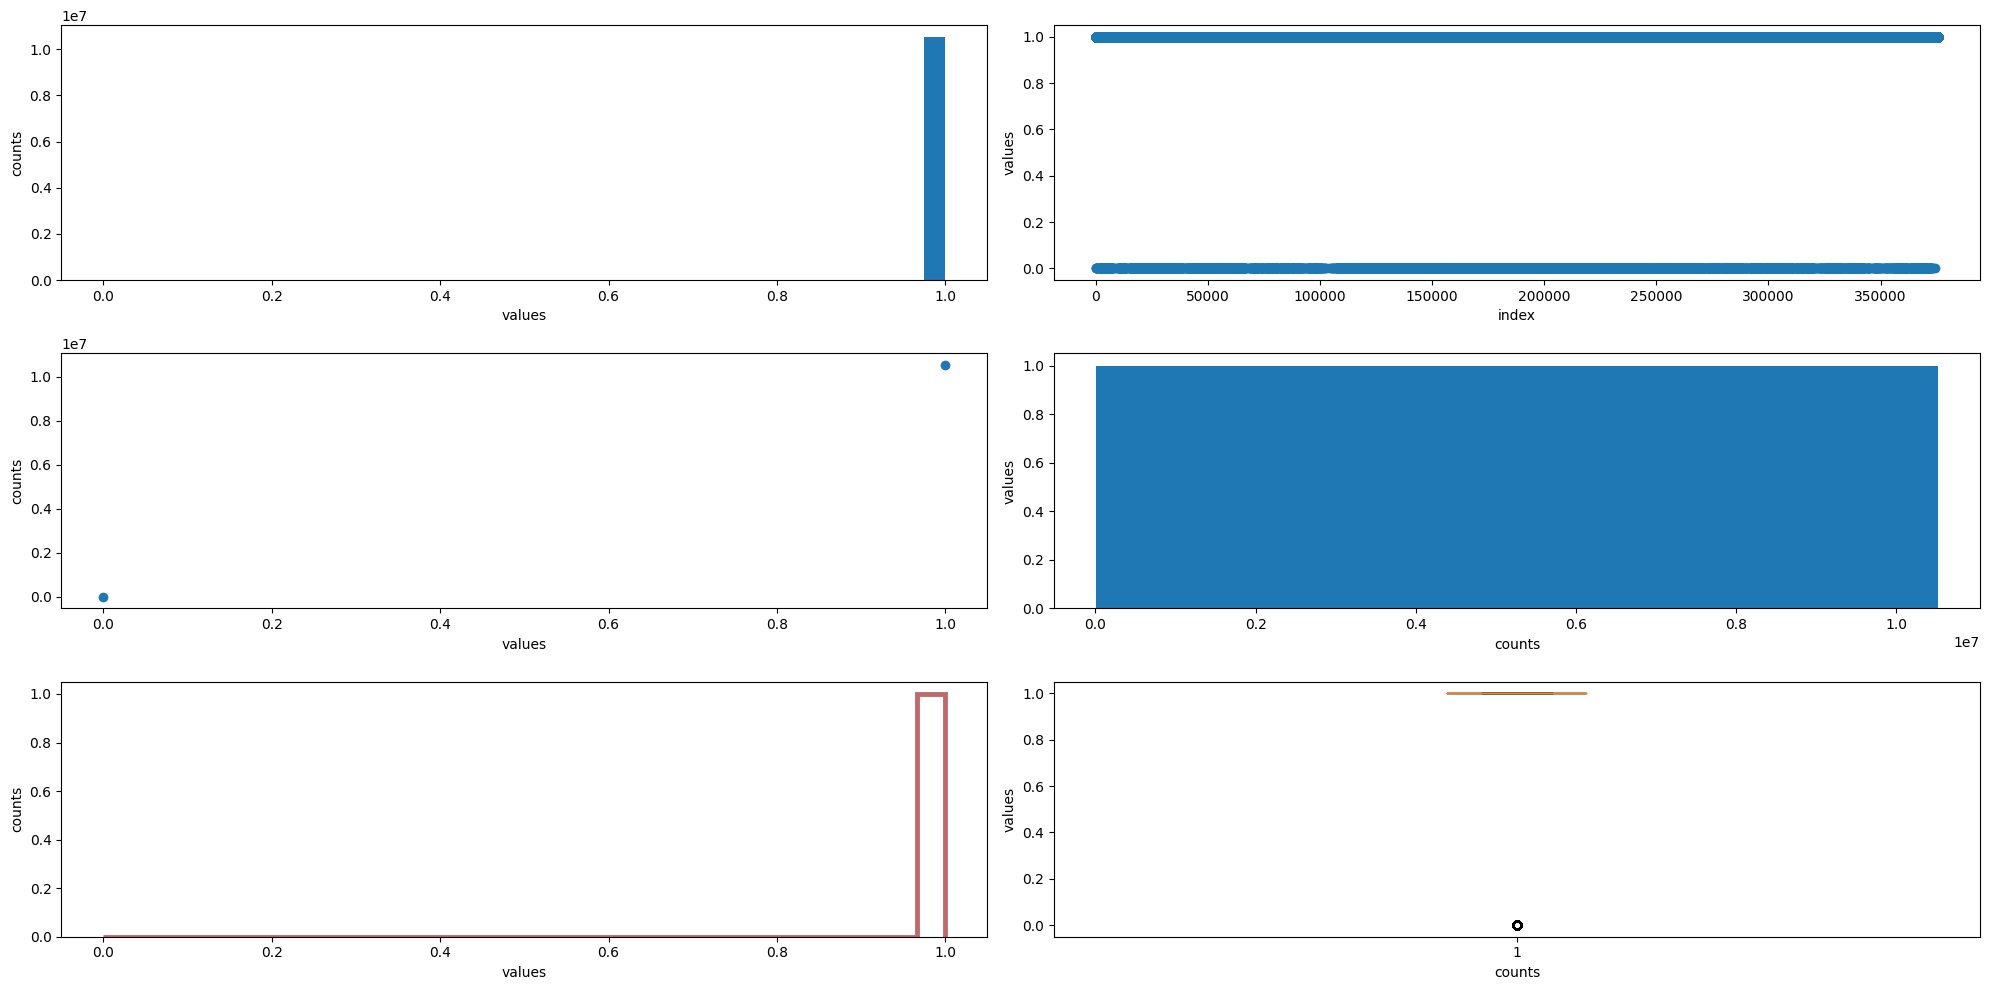

CPU times: user 19.5 s, sys: 1.47 s, total: 21 s
Wall time: 42.5 s


In [35]:
%%time
print(stats.describe(filtered_bbdd.is_renting))
filtered_bbdd.is_renting.describe()
show_counts(filtered_bbdd.is_renting.compute())

## 'is_returning'

DescribeResult(nobs=10525889, minmax=(0.0, 1.0), mean=0.9994678834253334, variance=0.0005318334771437129, skewness=-43.316139960409046, kurtosis=1874.287981069762)


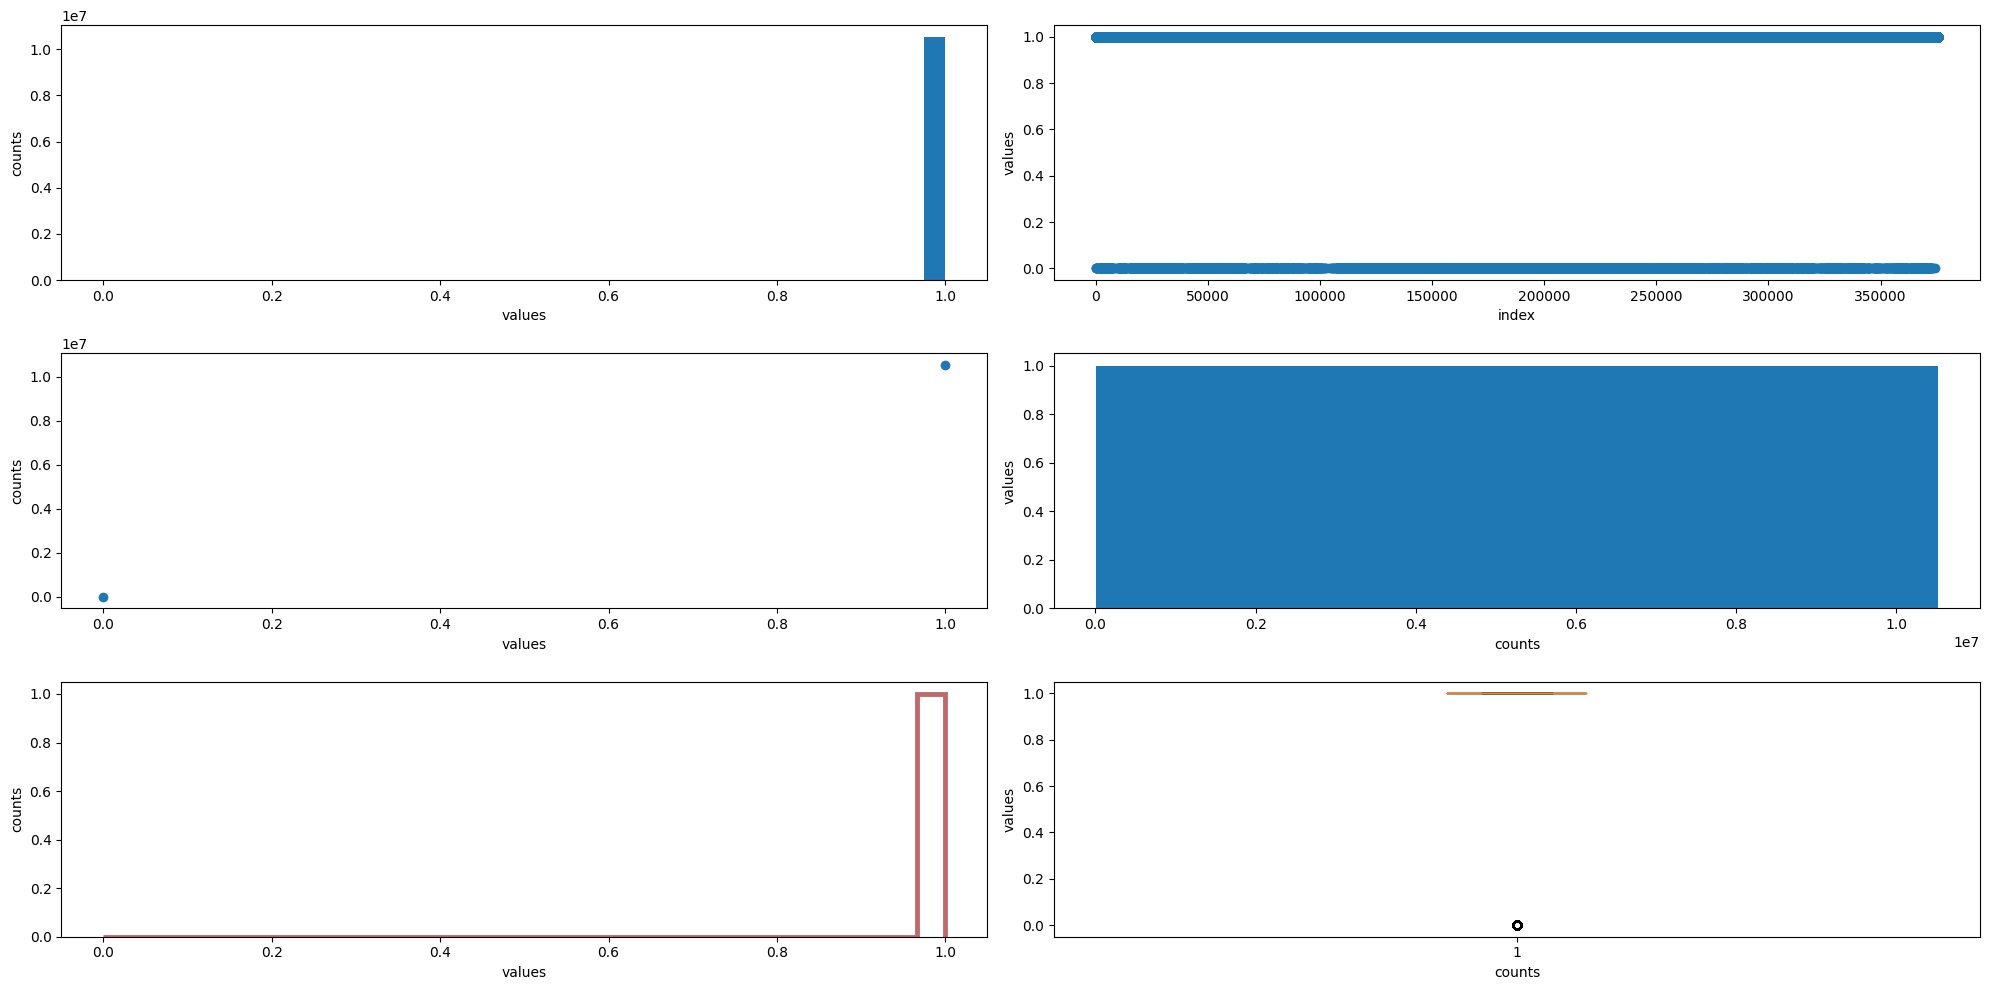

CPU times: user 19.3 s, sys: 1.33 s, total: 20.7 s
Wall time: 41.2 s


In [36]:
%%time
print(stats.describe(filtered_bbdd.is_returning))
filtered_bbdd.is_returning.describe()
show_counts(filtered_bbdd.is_returning.compute())

## 'is_charging_station'

## Study 

In [37]:
def filter_data(data, row_data, row_index):
    cat_cols = row_data.select_dtypes(include=['object']).columns
    num_cols = row_data.select_dtypes(exclude=['object']).columns
    
    filtered = data.copy()
    
    row = row_data.loc[row_index]
    for num_col in num_cols:
        filtered = filtered[filtered[num_col] == row[num_col]]
    
    for cat_col in cat_cols:
        filtered = filtered[filtered[cat_col].isin(row[cat_col])]
    
    return filtered

In [40]:
filtered_bbdd.groupby(
    [         
        'status',
        'is_renting', 
        'is_returning'
    ]
).station_id.sum().compute().reset_index().sort_values(['status','is_renting','is_returning']).reset_index(drop=True)


,status,is_renting,is_returning,station_id
0,0.0,0.0,0.0,1.095878e+06
1,0.0,1.0,1.0,9.321063e+07
2,1.0,0.0,0.0,1.185430e+05
3,1.0,0.0,1.0,2.109000e+03
4,1.0,1.0,1.0,2.182279e+09


In [41]:
status_of_station = filtered_bbdd.groupby(
    [         
        'status',
        'is_renting', 
        'is_returning'
    ]
)['station_id'].unique().compute()

status_of_station = pd.DataFrame(status_of_station).reset_index()
status_of_station = status_of_station.sort_values(['status','is_renting','is_returning']).reset_index(drop=True)
status_of_station

,status,is_renting,is_returning,station_id
0,0.0,0.0,0.0,"[332.0, 346.0, 344.0, 42.0, 339.0, 298.0, 290...."
1,0.0,1.0,1.0,"[1.0, 318.0, 311.0, 310.0, 321.0, 307.0, 305.0..."
2,1.0,0.0,0.0,"[396.0, 222.0, 89.0, 184.0, 351.0, 187.0, 424...."
3,1.0,0.0,1.0,"[94.0, 352.0, 223.0, 42.0, 351.0, 404.0, 78.0,..."
4,1.0,1.0,1.0,"[1.0, 320.0, 319.0, 318.0, 317.0, 316.0, 315.0..."


In [42]:
## view of the stations status

value counts stats {'max': 75, 'mean': 12.404938271604939, 'median': 10.0, 'std': 10.983289526386782, 'min': 1}


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 40.7 s, sys: 3.68 s, total: 44.3 s
Wall time: 4min 23s


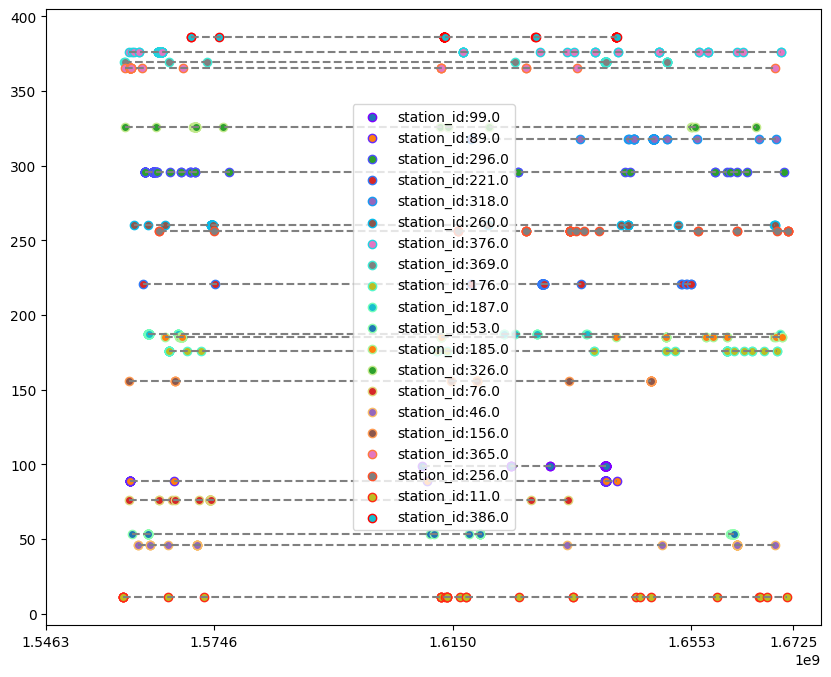

In [43]:
%%time

# status(r) 	is_renting 	is_returning 	
# 0.0 	          0.0 	        0.0 	
filtered = filter_data(filtered_bbdd, status_of_station, 0)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=False, 
    xticks=xticks,
    figsize=(10,8),
    count=20
)

value counts stats {'max': 2119, 'mean': 1044.1029411764705, 'median': 1031.0, 'std': 518.0190477664138, 'min': 179}


  0%|          | 0/5 [00:00<?, ?it/s]

2023-06-01 22:37:11,630 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.86 GiB -- Worker memory limit: 6.21 GiB
2023-06-01 22:37:25,196 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.85 GiB -- Worker memory limit: 6.21 GiB


CPU times: user 11.9 s, sys: 961 ms, total: 12.8 s
Wall time: 1min 17s


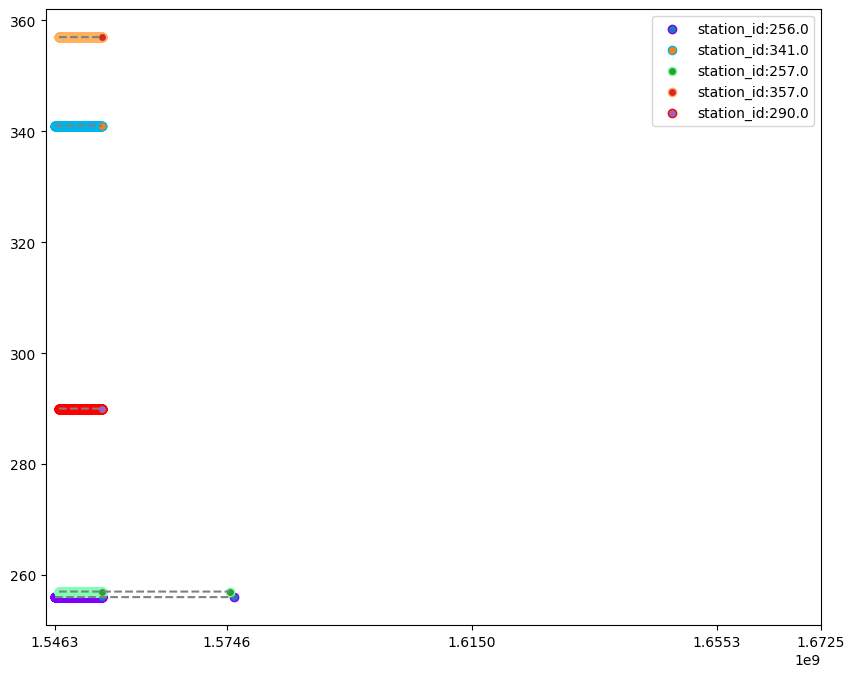

In [44]:
%%time

# status(r) 	is_installed 	is_renting 	is_returning 	
# 0.0 	1.0 	1.0
filtered = filter_data(filtered_bbdd, status_of_station, 1)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=False, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 7, 'mean': 1.969283276450512, 'median': 2.0, 'std': 1.1626663225959617, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

2023-06-01 22:38:19,476 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.87 GiB -- Worker memory limit: 6.21 GiB
2023-06-01 22:38:32,623 - distributed.worker.memory - WARNING - Worker is at 91% memory usage. Pausing worker.  Process memory: 5.68 GiB -- Worker memory limit: 6.21 GiB
2023-06-01 22:38:32,821 - distributed.worker.memory - WARNING - Worker is at 62% memory usage. Resuming worker. Process memory: 3.87 GiB -- Worker memory limit: 6.21 GiB
2023-06-01 22:38:33,257 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memo

CPU times: user 12.3 s, sys: 1.12 s, total: 13.4 s
Wall time: 1min 22s


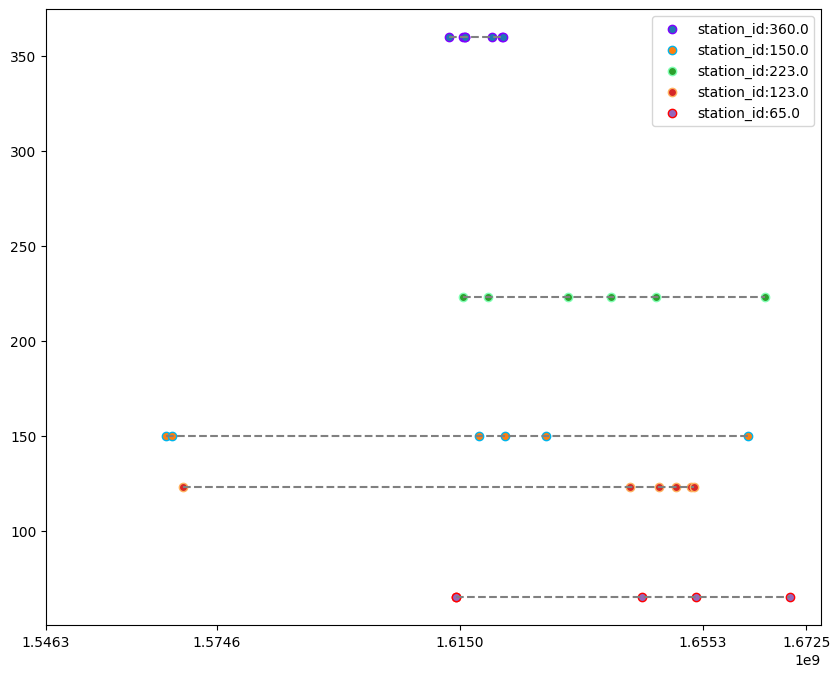

In [45]:
%%time

# status(r) 	is_installed 	is_renting 	is_returning 	
# 1.0 	0.0 	0.0
filtered = filter_data(filtered_bbdd, status_of_station, 2)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=False, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

2023-06-01 22:39:02,350 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.86 GiB -- Worker memory limit: 6.21 GiB


value counts stats {'max': 1, 'mean': 1.0, 'median': 1.0, 'std': 0.0, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

2023-06-01 22:39:16,332 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.88 GiB -- Worker memory limit: 6.21 GiB
2023-06-01 22:39:44,164 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.89 GiB -- Worker memory limit: 6.21 GiB
2023-06-01 22:39:58,331 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

CPU times: user 12.6 s, sys: 1.13 s, total: 13.7 s
Wall time: 1min 24s


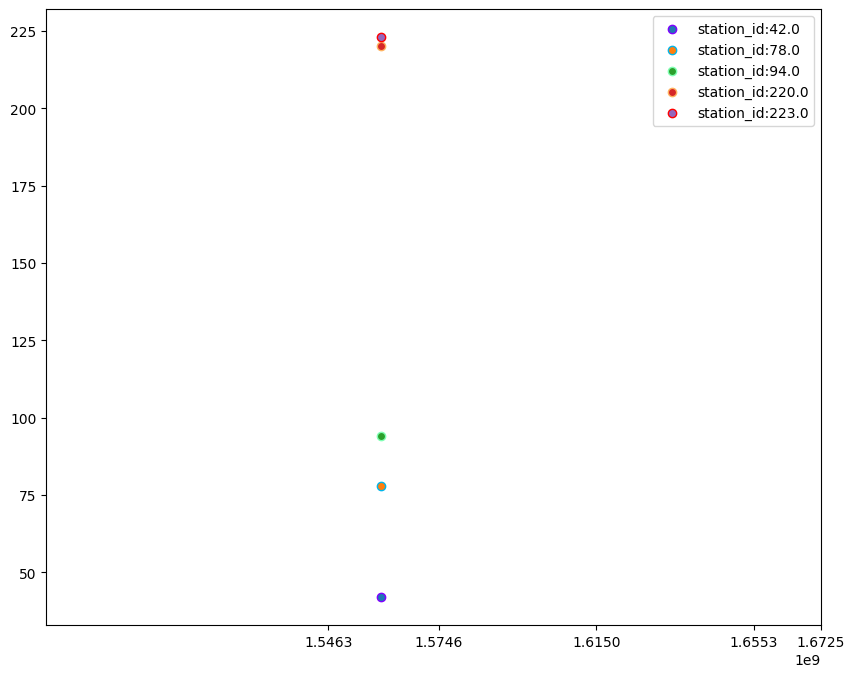

In [46]:
%%time

# status(r) 	is_installed 	is_renting 	is_returning 	
# 1.0 	0.0 	1.0
filtered = filter_data(filtered_bbdd, status_of_station, 3)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=False, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

# Goal Columns 

## 'num_docks_available' 

2023-06-01 22:41:24,297 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.90 GiB -- Worker memory limit: 6.21 GiB


DescribeResult(nobs=10525889, minmax=(0.0, 54.0), mean=15.708773390326614, variance=75.89004317339176, skewness=0.10128151691796286, kurtosis=-0.3525971648818609)


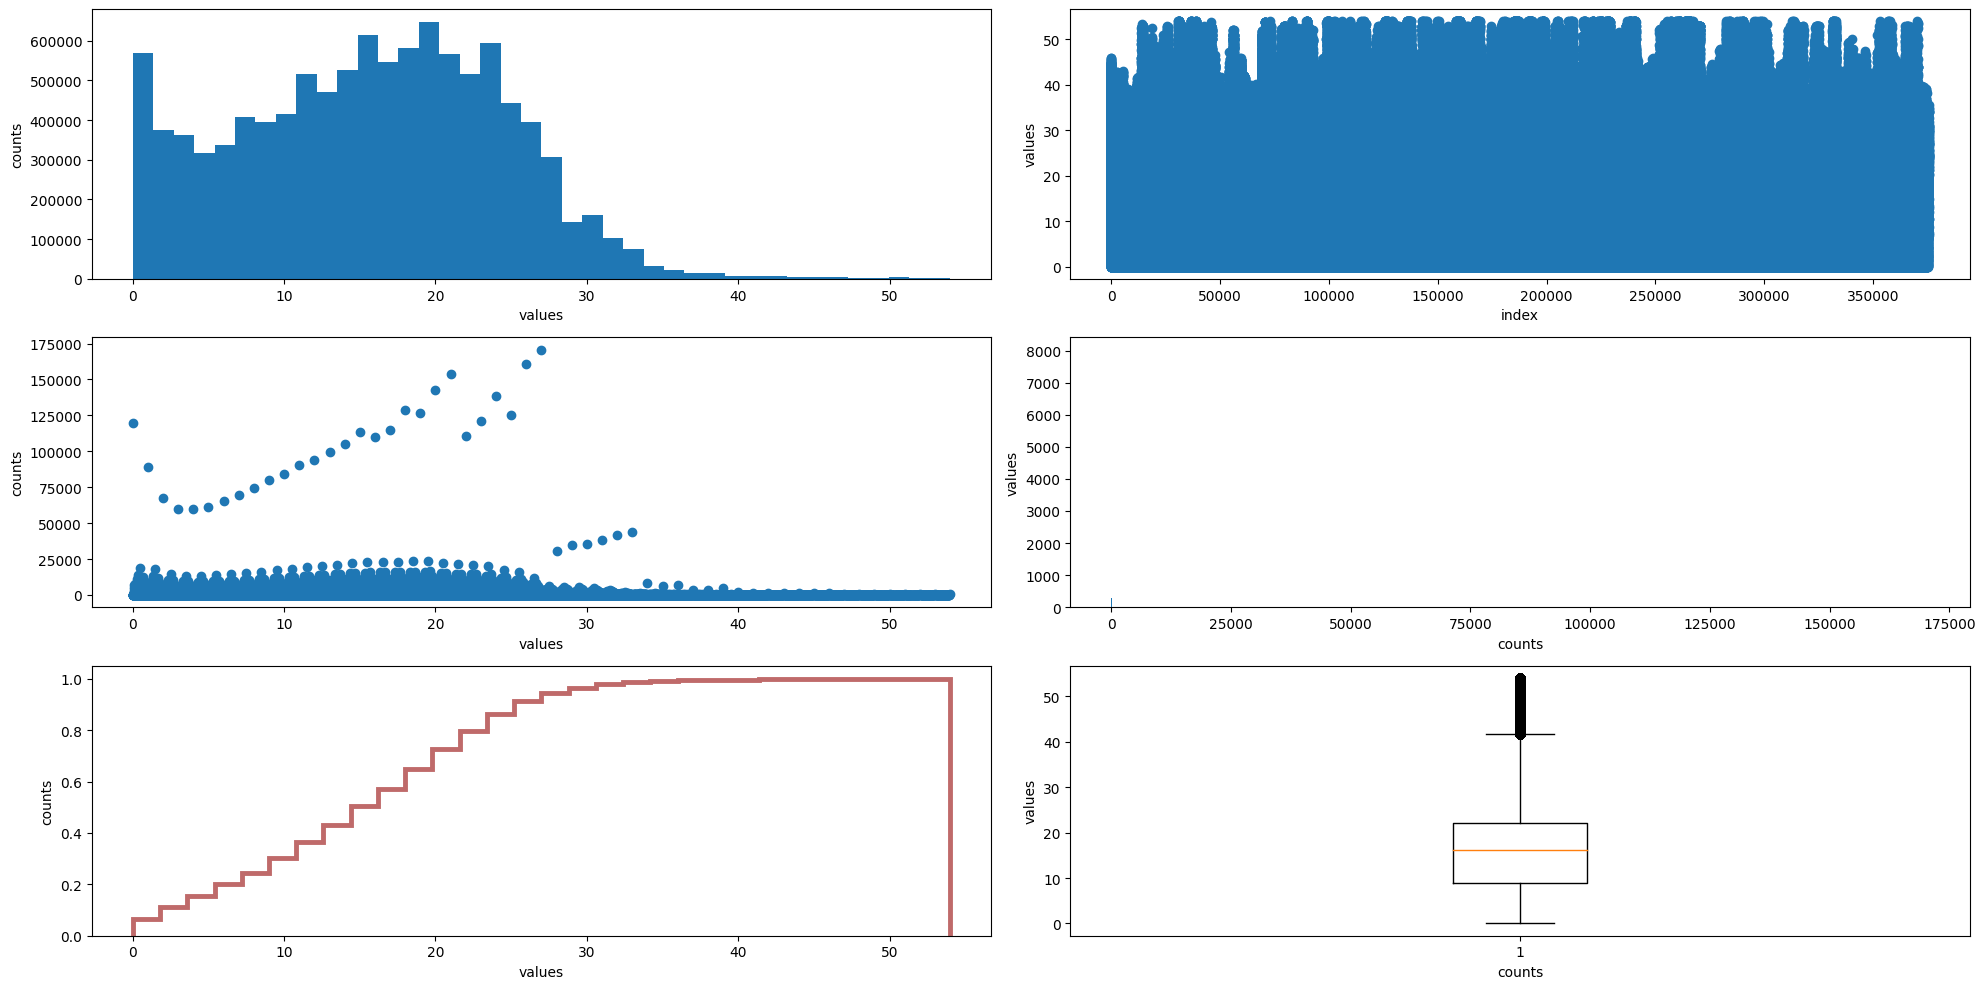

CPU times: user 33.9 s, sys: 4.22 s, total: 38.1 s
Wall time: 56.7 s


In [48]:
%%time
print(stats.describe(filtered_bbdd.num_docks_available))
filtered_bbdd.num_docks_available.describe()
show_counts(filtered_bbdd.num_docks_available.compute())

## 'num_bikes_available' 

2023-06-01 22:42:20,677 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.90 GiB -- Worker memory limit: 6.21 GiB


DescribeResult(nobs=10525889, minmax=(-0.1666666666666666, 54.0), mean=9.913773717709297, variance=71.12285967541705, skewness=0.8521300528238549, kurtosis=0.43824205202592514)


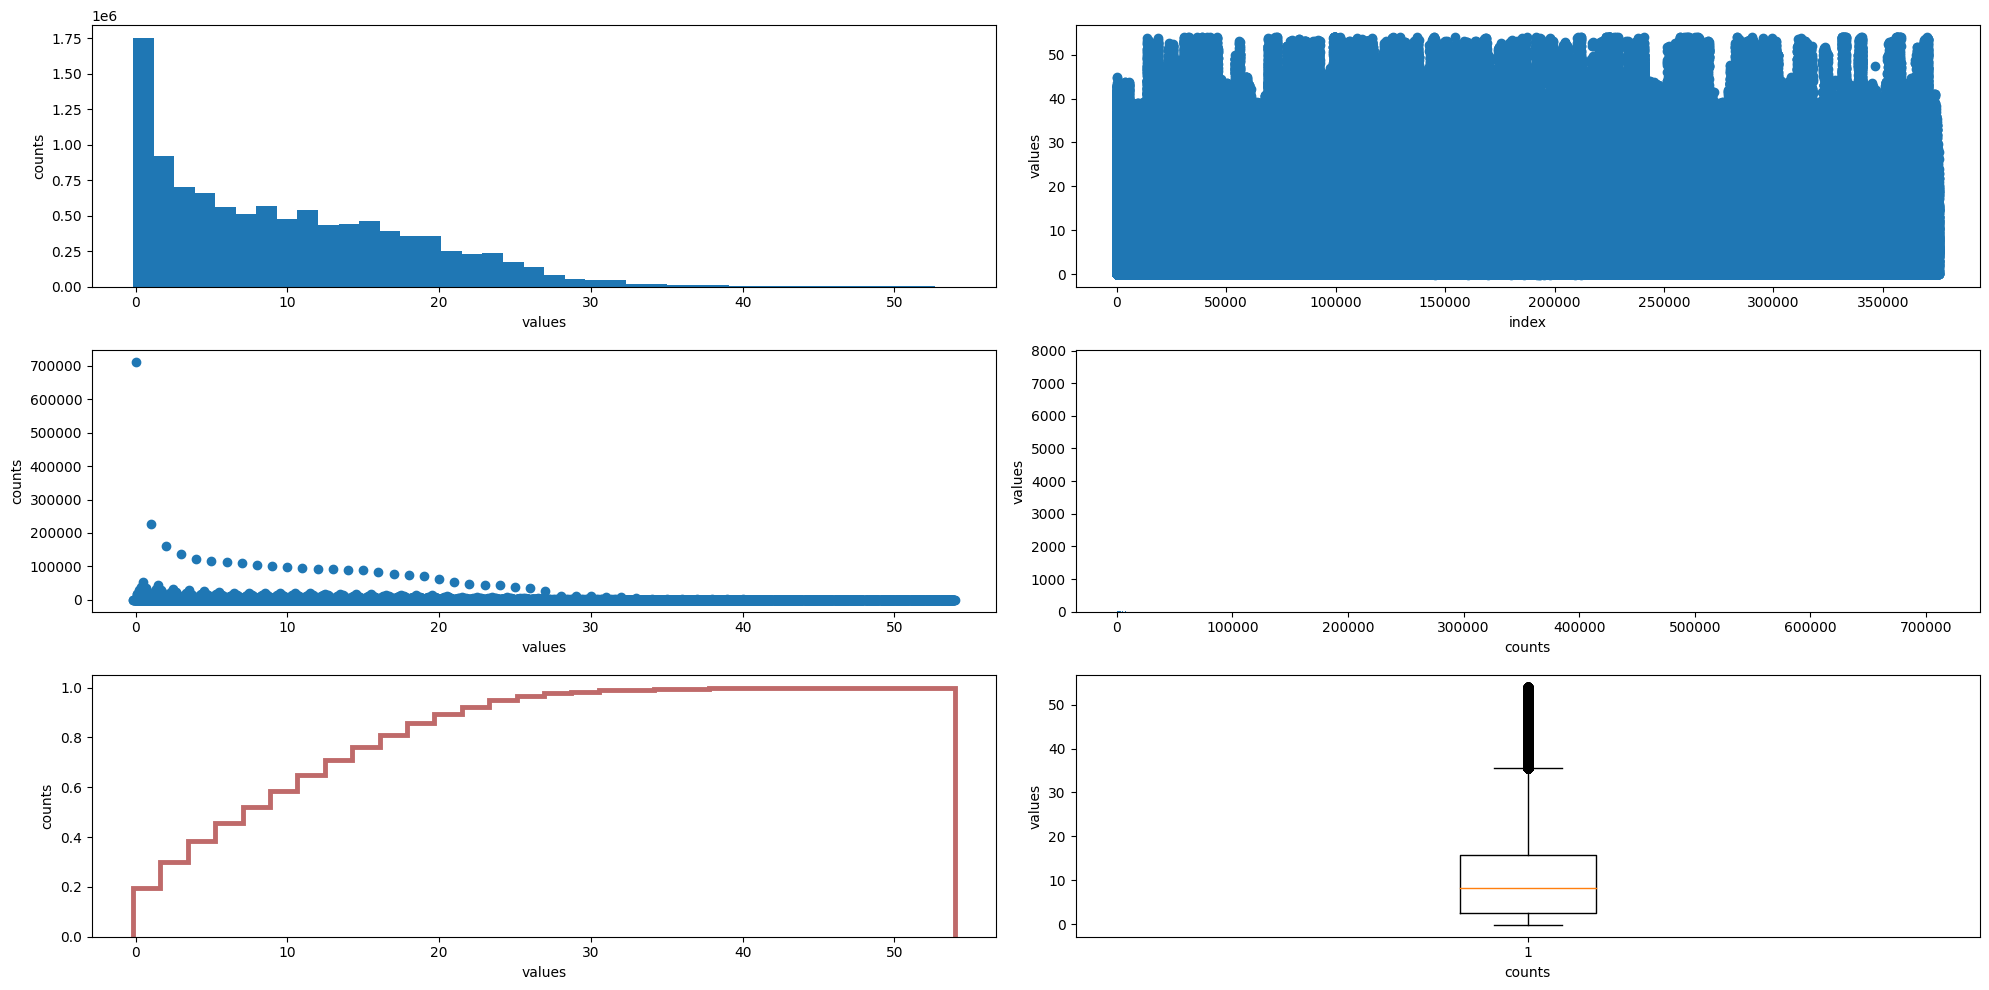

CPU times: user 31.7 s, sys: 2.82 s, total: 34.5 s
Wall time: 54.2 s


In [49]:
%%time
print(stats.describe(filtered_bbdd.num_bikes_available))
filtered_bbdd.num_bikes_available.describe()
show_counts(filtered_bbdd.num_bikes_available.compute())

## 'num_bikes_available_types.mechanical'

DescribeResult(nobs=10525889, minmax=(-0.1666666666666666, 54.0), mean=8.331989219702969, variance=66.3180446322069, skewness=0.997502976628675, kurtosis=0.6302251158013714)


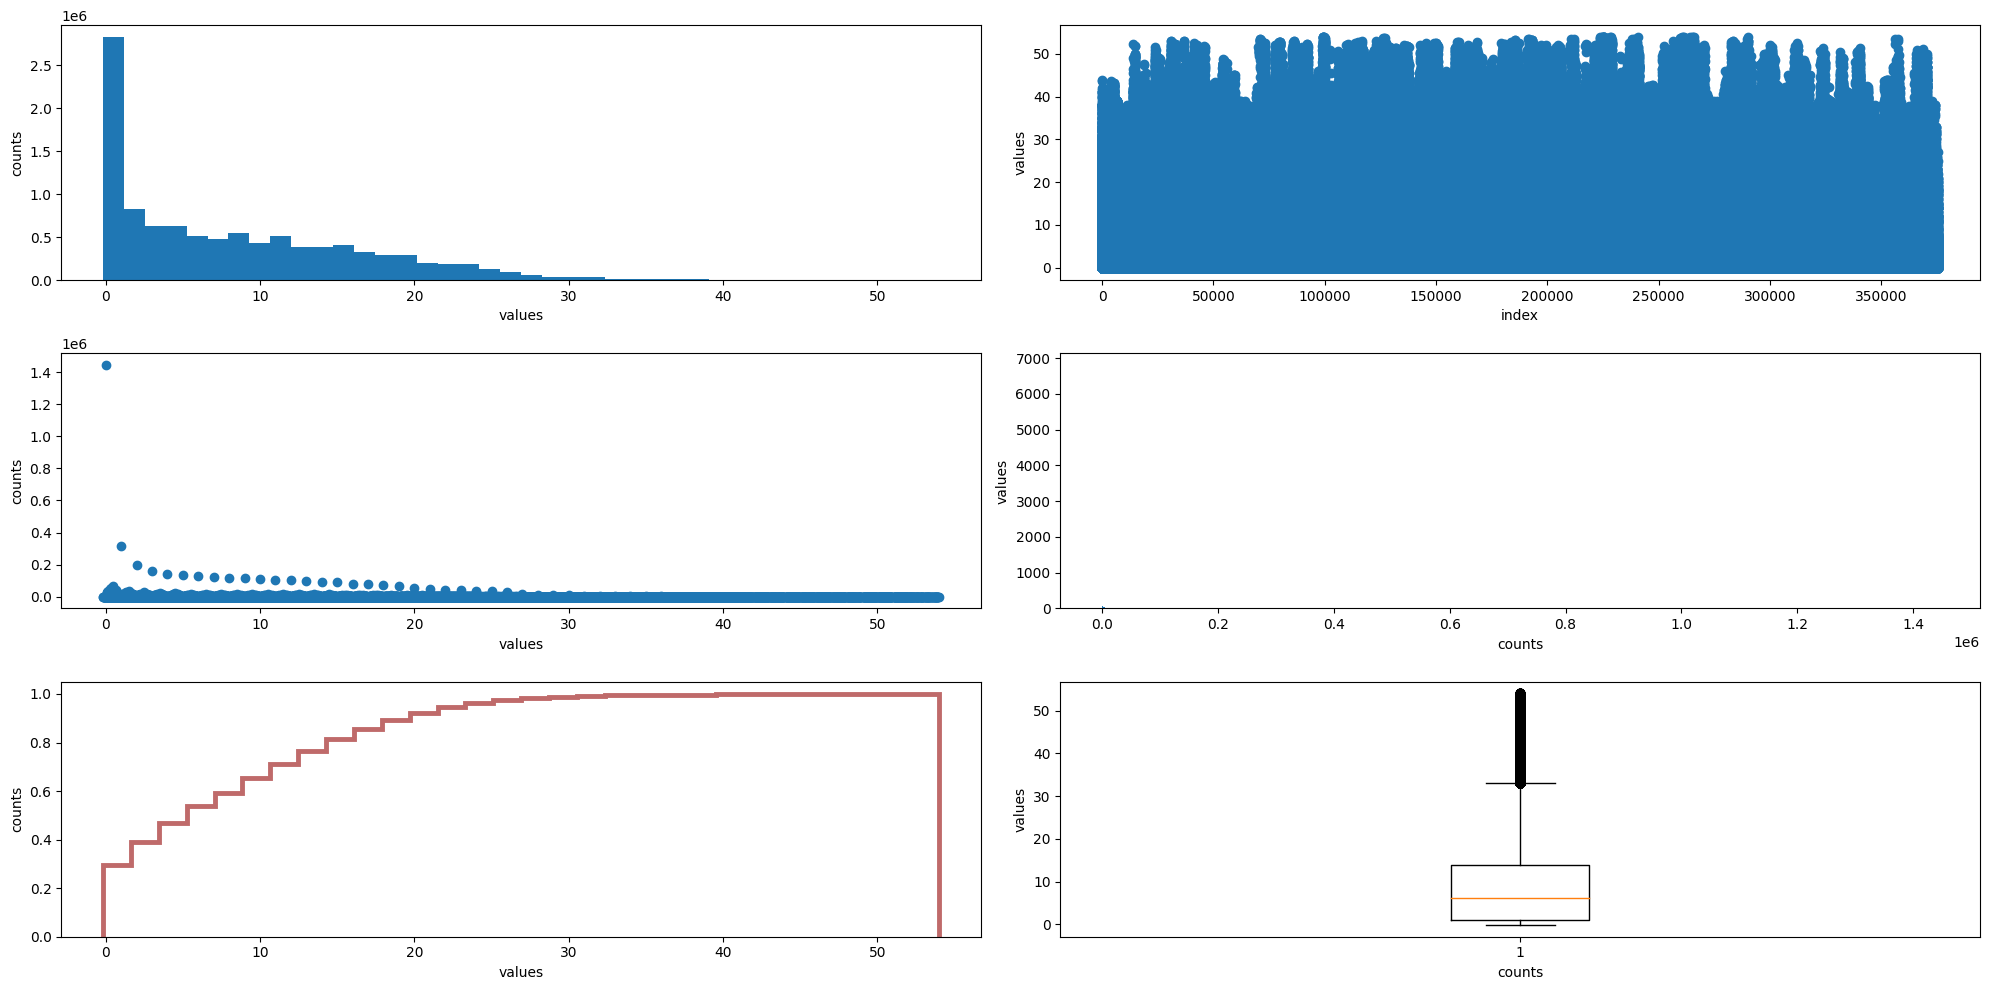

CPU times: user 30 s, sys: 2.84 s, total: 32.8 s
Wall time: 52.6 s


In [50]:
%%time
print(stats.describe(filtered_bbdd['num_bikes_available_types.mechanical']))
filtered_bbdd['num_bikes_available_types.mechanical'].describe()
show_counts(filtered_bbdd['num_bikes_available_types.mechanical'].compute())

## 'num_bikes_available_types.ebike'

2023-06-01 22:44:07,489 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.93 GiB -- Worker memory limit: 6.21 GiB


DescribeResult(nobs=10525889, minmax=(0.0, 37.0), mean=1.5818160196972106, variance=7.137064189049149, skewness=3.226015031675948, kurtosis=13.977887479560682)


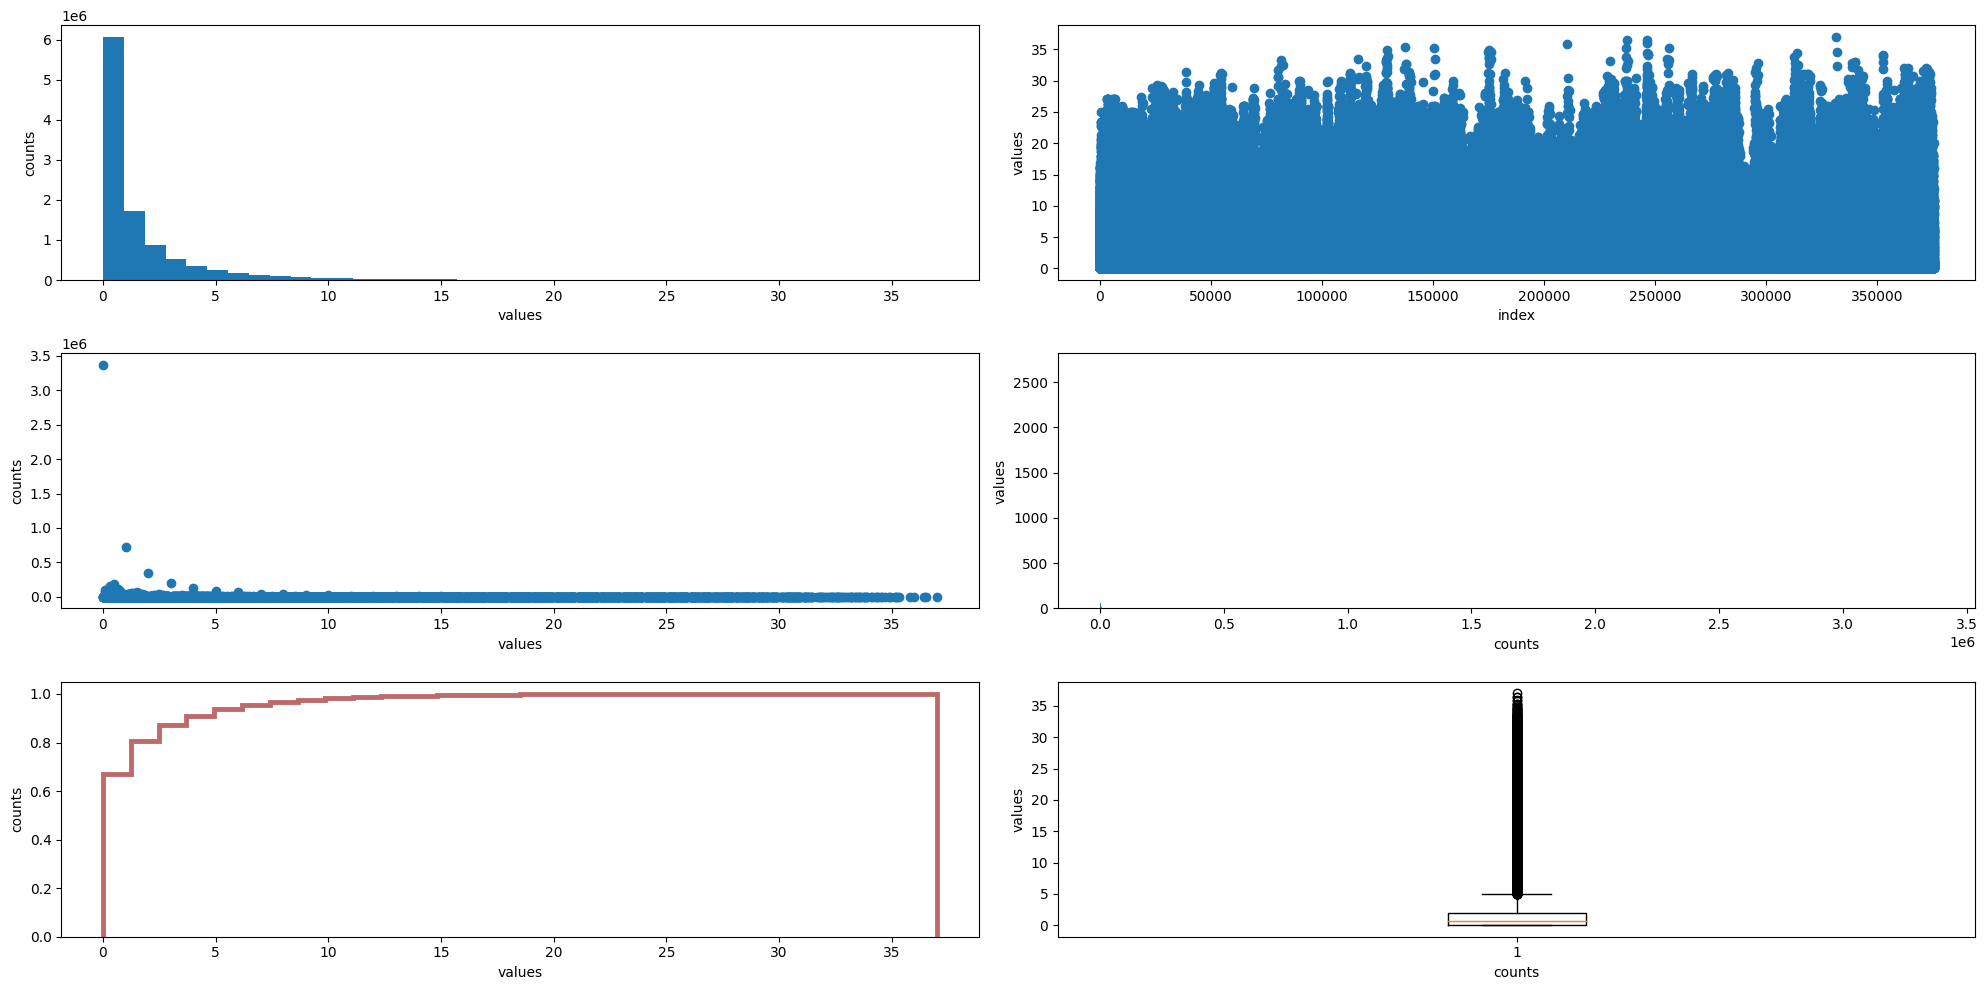

CPU times: user 23.6 s, sys: 2 s, total: 25.6 s
Wall time: 46.2 s


In [51]:
%%time
print(stats.describe(filtered_bbdd['num_bikes_available_types.ebike']))
filtered_bbdd['num_bikes_available_types.ebike'].describe()
show_counts(filtered_bbdd['num_bikes_available_types.ebike'].compute())

## 'capacity' 

DescribeResult(nobs=10525889, minmax=(12.000000000000004, 54.00000000000003), mean=27.380048310005698, variance=36.10102455402272, skewness=1.3291222910047569, kurtosis=3.9515097374090686)


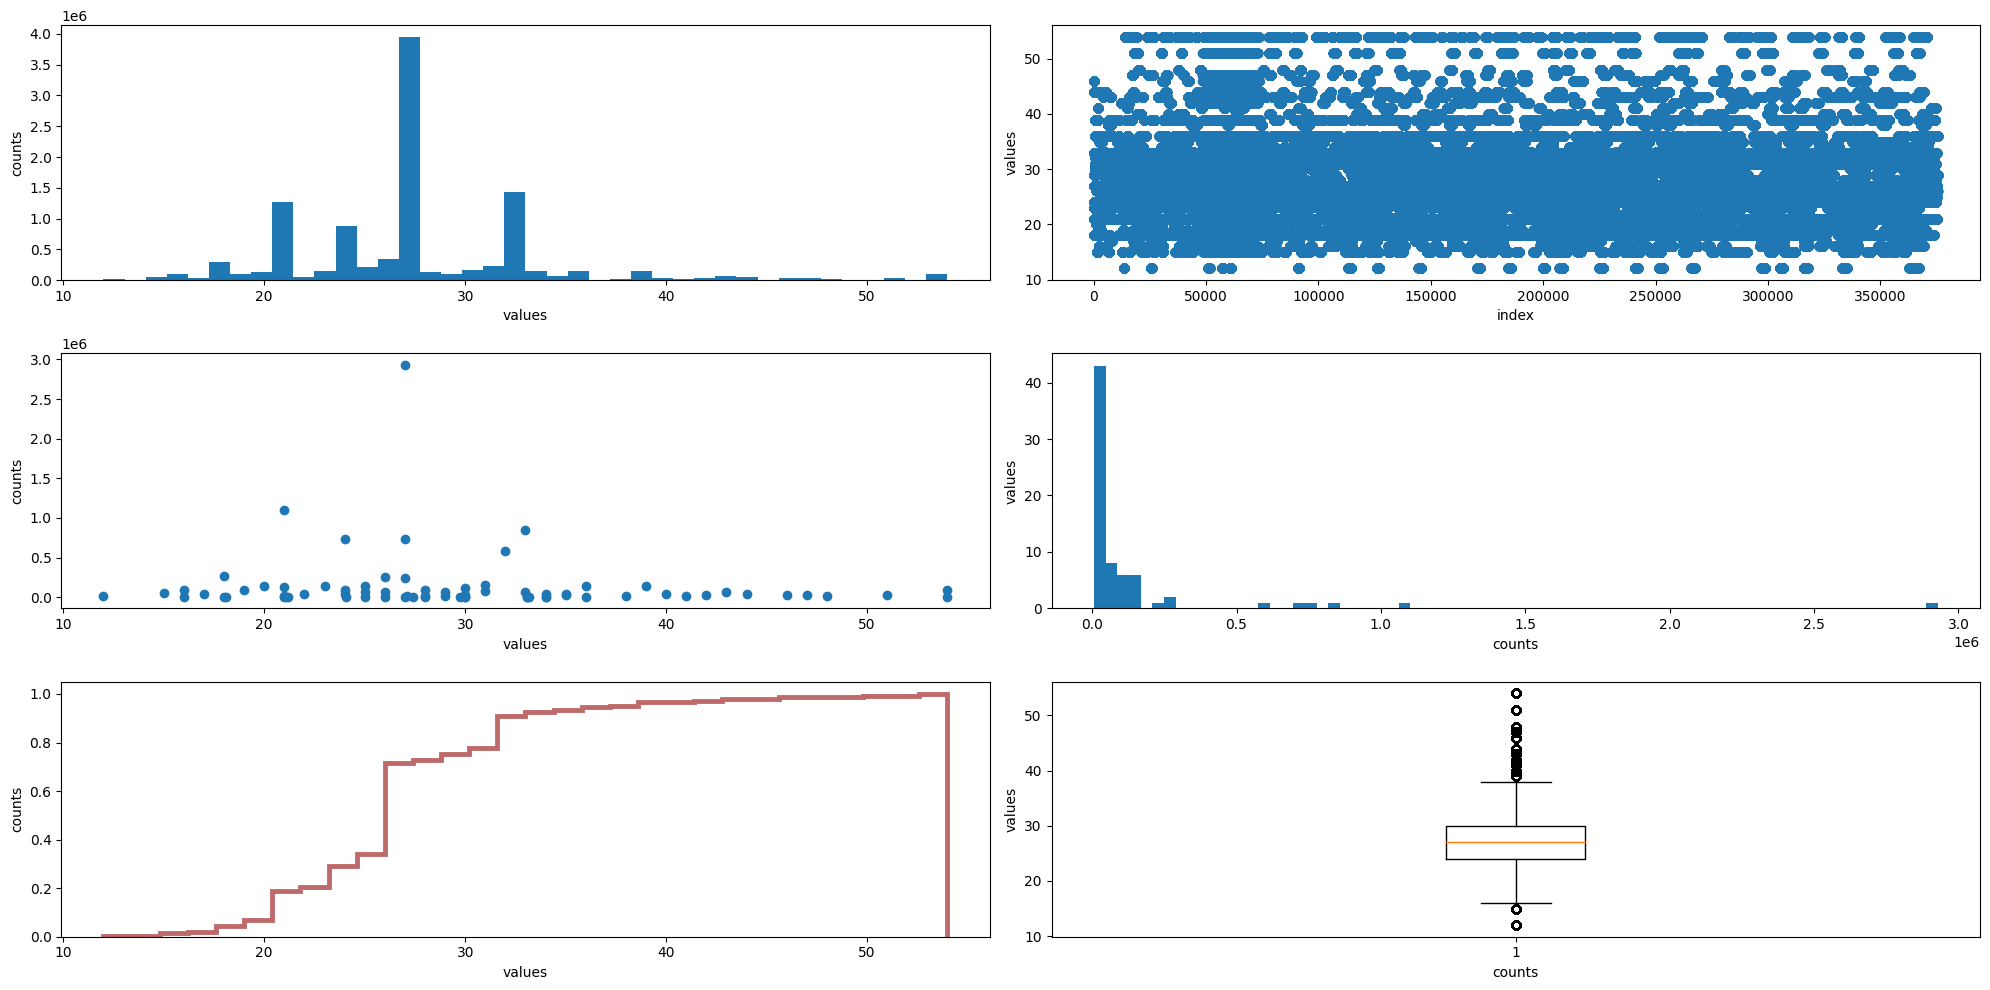

CPU times: user 20.2 s, sys: 1.38 s, total: 21.6 s
Wall time: 43.4 s


In [52]:
%%time
print(stats.describe(filtered_bbdd.capacity))
filtered_bbdd.capacity.describe()
show_counts(filtered_bbdd.capacity.compute())

## 'ctx0'

2023-06-01 22:45:36,748 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.94 GiB -- Worker memory limit: 6.21 GiB


DescribeResult(nobs=10525889, minmax=(0.0, 1.0), mean=0.5736749653870641, variance=0.08499918222468698, skewness=-0.37415983336019976, kurtosis=-1.0225259756287979)


2023-06-01 22:45:51,288 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.92 GiB -- Worker memory limit: 6.21 GiB


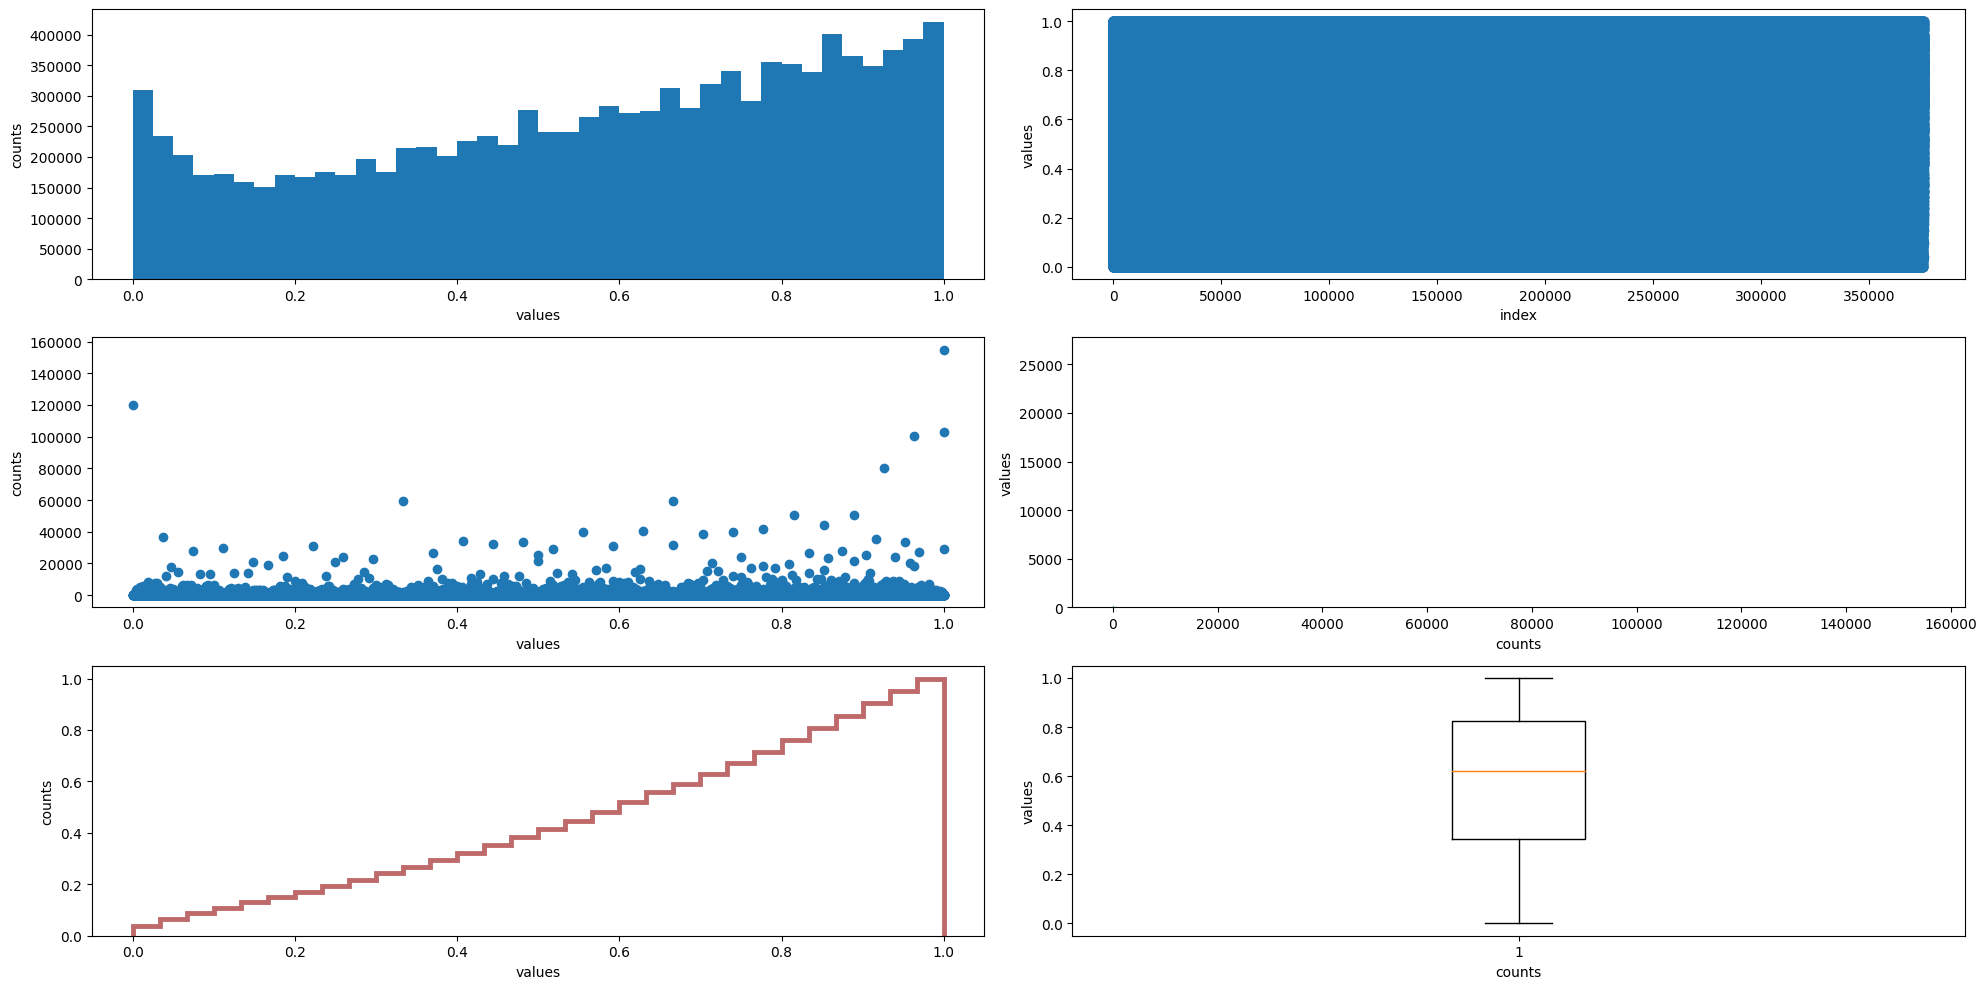

CPU times: user 1min 47s, sys: 13.3 s, total: 2min
Wall time: 2min 9s


In [53]:
%%time
print(stats.describe(filtered_bbdd.ctx0))
filtered_bbdd.ctx0.describe()
show_counts(filtered_bbdd.ctx0.compute())

## · Visualización de la disponibilidad de bicicletas
Gráficos para visualizar la disponibilidad de bicicletas a lo largo del tiempo. Ejemplo: cantidad de bicicletas disponibles en función del tiempo para identificar patrones diarios, semanales o estacionales.

## · Análisis temporal
Datos por año, mes, día de la semana o hora del día para conocer estadísticas agregadas, como el promedio de bicicletas disponibles o el porcentaje de anclajes disponibles. Tendencias temporales y patrones de uso.

## · Relación entre variables
Explorar si hay una correlación entre el número de anclajes disponibles (num_docks_available) y el número de bicicletas disponibles (num_bikes_available). Investigar si la disponibilidad de bicicletas difiere entre los diferentes tipos de bicicletas (mecánicas y eléctricas).

## · Análisis de capacidad y porcentaje de anclajes disponibles
Capacidad (capacity) y los porcentajes de anclajes disponibles (ctx0, ctx1, ctx2, ctx3, ctx4). Promedio distribución de la capacidad y los porcentajes de anclajes disponibles. Objetivo: entender la utilización de las estaciones de bicicletas a lo largo del tiempo.

## Data Cleaning

In [58]:
import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

client.run(trim_memory)

{'tcp://127.0.0.1:37089': 1,
 'tcp://127.0.0.1:38639': 1,
 'tcp://127.0.0.1:43789': 1,
 'tcp://127.0.0.1:45449': 1,
 'tcp://127.0.0.1:45503': 1}

In [62]:
%%time

stations = filtered_bbdd[['timestamp', 'station_id', 'ctx0']].compute()

CPU times: user 2.36 s, sys: 540 ms, total: 2.9 s
Wall time: 16.4 s


In [63]:
%%time 

# test 

cond = stations.station_id.isin([1])
station_data = stations[cond]
station_group = station_data.groupby(['timestamp', 'station_id'])
station_counts = station_group.ctx0.count()
station_mean = station_group.ctx0.mean()
(station_counts > 1).any()

CPU times: user 352 ms, sys: 8.36 ms, total: 360 ms
Wall time: 343 ms


False

In [64]:
station_counts = station_counts.reset_index()
station_counts

,timestamp,station_id,ctx0
0,1.546301e+09,1.0,1
1,1.546304e+09,1.0,1
2,1.546308e+09,1.0,1
3,1.546312e+09,1.0,1
4,1.546315e+09,1.0,1
...,...,...,...
24620,1.672513e+09,1.0,1
24621,1.672517e+09,1.0,1
24622,1.672520e+09,1.0,1
24623,1.672524e+09,1.0,1


In [65]:
station_counts.timestamp.to_list()

[1546300800.0,
 1546304400.0,
 1546308000.0,
 1546311600.0,
 1546315200.0,
 1546318800.0,
 1546322400.0,
 1546326000.0,
 1546329600.0,
 1546333200.0,
 1546336800.0,
 1546340400.0,
 1546344000.0,
 1546347600.0,
 1546351200.0,
 1546354800.0,
 1546358400.0,
 1546362000.0,
 1546365600.0,
 1546369200.0,
 1546372800.0,
 1546376400.0,
 1546380000.0,
 1546383600.0,
 1546387200.0,
 1546390800.0,
 1546394400.0,
 1546398000.0,
 1546401600.0,
 1546405200.0,
 1546408800.0,
 1546412400.0,
 1546416000.0,
 1546419600.0,
 1546423200.0,
 1546426800.0,
 1546430400.0,
 1546434000.0,
 1546437600.0,
 1546441200.0,
 1546444800.0,
 1546448400.0,
 1546452000.0,
 1546455600.0,
 1546459200.0,
 1546462800.0,
 1546466400.0,
 1546470000.0,
 1546473600.0,
 1546477200.0,
 1546480800.0,
 1546484400.0,
 1546488000.0,
 1546491600.0,
 1546495200.0,
 1546498800.0,
 1546502400.0,
 1546506000.0,
 1546509600.0,
 1546513200.0,
 1546516800.0,
 1546520400.0,
 1546524000.0,
 1546527600.0,
 1546531200.0,
 1546534800.0,
 154653840

In [66]:
station_mean = station_mean.reset_index()
station_mean

,timestamp,station_id,ctx0
0,1.546301e+09,1.0,0.181818
1,1.546304e+09,1.0,0.156126
2,1.546308e+09,1.0,0.164032
3,1.546312e+09,1.0,0.191700
4,1.546315e+09,1.0,0.104743
...,...,...,...
24620,1.672513e+09,1.0,0.125604
24621,1.672517e+09,1.0,0.111801
24622,1.672520e+09,1.0,0.119565
24623,1.672524e+09,1.0,0.158385


In [67]:
station_mean[(station_counts.ctx0 > 1)]

,timestamp,station_id,ctx0


In [68]:
%%time

stations = filtered_bbdd[['timestamp', 'station_id', 'ctx0']].compute()

CPU times: user 2.43 s, sys: 607 ms, total: 3.04 s
Wall time: 17.8 s


In [69]:
stations.columns

Index(['timestamp', 'station_id', 'ctx0'], dtype='object')

In [71]:
stations.shape

(10099895, 3)

In [72]:
stations.drop_duplicates(subset=['timestamp', 'station_id'], keep='last', inplace=True)

In [73]:
stations.shape

(10099895, 3)

In [74]:
stations.index.to_list()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,

In [70]:
get_ddf_shape(filtered_bbdd)

(10099895, 21)

In [75]:
get_ddf_shape(nonfiltered_bbdd)

(1769379, 21)

# Datos adicionales
Tiempo, festivos Barcelona